# Forecasting Electricity Price in Spain

In [1]:
# Import all the necessary libraries
# Standard Libraries
import os
from math import sqrt
from matplotlib import pyplot

# Data Manipulation and Analysis Libraries
import pandas as pd
import numpy as np

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis Libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from scipy import stats

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import plot_importance

In [2]:
# Load the datasets

df_weather = pd.read_csv('weather_features.csv',parse_dates=['dt_iso'])

df_energy = pd.read_csv('energy_dataset.csv',parse_dates=['time'])

RMSE: 13.249856853754762
R-squared: 0.12982152162245753
MAE: 10.485264658909424


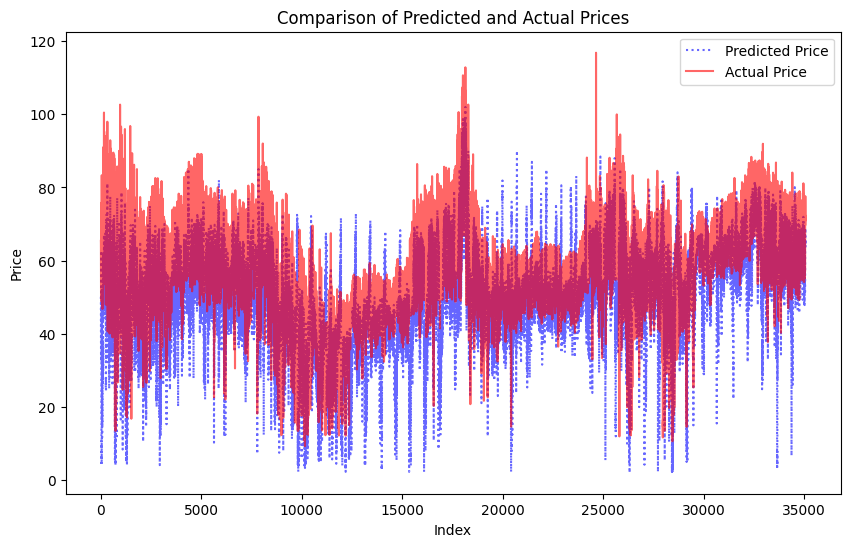

In [3]:
# Calculate RMSE for the original predictions
rmse = np.sqrt(mean_squared_error(df_energy['price actual'], df_energy['price day ahead']))
# Calculate R-squared
r_squared = r2_score(df_energy['price actual'], df_energy['price day ahead'])
# Calculate MAE
mae = mean_absolute_error(df_energy['price actual'], df_energy['price day ahead'])

# Print the metrics
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")
print(f"MAE: {mae}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy['price day ahead'], label='Predicted Price', color='blue', alpha=0.6, linestyle='dotted')
plt.plot(df_energy['price actual'], label='Actual Price', color='red', alpha=0.6)
plt.title('Comparison of Predicted and Actual Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

The original data's error metrics provide a baseline against which the performance of various predictive models can be evaluated. Here's an interpretation of the original model's performance based on its error metrics:

1. RMSE (Root Mean Square Error) of 13.2499: This value indicates the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. A value of 13.2499 suggests that, on average, the model's predictions are about 13.2499 units away from the actual values. For some contexts, this might be acceptable, but for others, especially those requiring precise predictions, it might be considered too high.

2. MAE (Mean Absolute Error) of 10.4853: This measures the average magnitude of the errors in a set of predictions, without considering their direction. An MAE of 10.4853 means that, on average, the model's predictions are about 10.4853 units away from the actual value. Compared to RMSE, MAE is not as sensitive to outliers, so this might suggest the model's predictions are generally closer to actual values than the RMSE might indicate, but it still shows room for improvement.

3. R-squared (Coefficient of Determination) of 0.1298: This metric indicates the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. An R-squared of 0.1298 is quite low, suggesting that the model explains only about 12.98% of the variability in the target variable. This low value indicates a poor fit to the data, meaning the model, as it is currently specified, does not capture much of the variance in the dependent variable and is not an effective predictor.

Inference:

The initial interpretation of the original data's error metrics suggests that the predictive performance of the original model is relatively poor. The model's predictions are, on average, about 10 to 13 units off from the actual values, and it explains less than 13% of the variance in the dependent variable. This indicates a significant opportunity for improvement through model tuning, feature engineering, or trying different modeling approaches. Given the subsequent performances of other models like RandomForest, LightGBM, and XGBOOST, which have much better RMSE, MAE, and R-squared values, it's clear that alternative approaches can provide more accurate predictions and better capture the variability of the dependent variable.

## Energy data

In [4]:
# Exploring the energy dataset
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

We will drop all the columns that are constituted by zeroes and NaNs, as they are unusable. We will also remove the columns which will not be used at all in our analysis and which contain day-ahead forecasts for the total load, the solar energy and the wind energy.

In [5]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [6]:
df_energy.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil gas  generation fossil hard coal  \
count               35046.00                     35046.00   
mean                 5622.74                      4256.07   
std                  2201.83                      1961.60   
min                     0.00                         0.00   
25%                  4126.00                      2527.00   
50%                  4969.00                      4474.00   
75%                  6429.00                      5838.75   
max                 20034.00                      8359.00   

       generation fossil oil  generation hydro pumped storage consumption  \
count               35045.00                                     35045.00   
mean                  298.32                                       475.58   
std                    52.52                                       792.41   
min                     0.00                                         0.00   
25%                   263.00                                         0.00   
50%                   300.00                                        68.00   
75%                   330.00                                       616.00   
max                   449.00                                      4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water reservoir  generation nuclear  generation other  \
count                          35046.00            35047.00          35046.00   
mean                            2605.11             6263.91             60.23   
std                             1835.20              839.67             20.24   
min                                0.00                0.00              0.00   
25%                             1077.25             5760.00             53.00   
50%                             2164.00             6566.00             57.00   
75%                             3757.00             7025.00             80.00   
max                             9728.00             7117.00            106.00   

       generation other renewable  generation solar  generation waste  \
count                    35046.00          35046.00          35045.00   
mean                        85.64           1432.67            269.45   
std                         14.08           1680.12             50.20   
min                          0.00              0.00              0.00   
25%                         73.00             71.00            240.00   
50%                         88.00            616.00            279.00   
75%                         97.00           2578.00            310.00   
max                        119.00           5792.00            357.00   

       generation wind onshore  total load actual  price day ahead  \
count                 35046.00           35028.00         35064.00   
mean                   5464.48           28696.94            49.87   
std                    3213.69            4574.99            14.62   
min          

In [7]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [8]:
# Check duplicates and NaNs in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


`df_energy` contains no duplicates. It has a few NaNs values. We need to investigate further. As this is a time-series forecasting task, we will not drop the rows  and their missing values as we can fill the missing values using interpolation.

In [9]:
# Number of NaNs in each column

df_energy.isnull().sum(axis=0)

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Most null values can be found in the 'total load actual' column. There are no NaNs in the 'price actual' column, which is our target variable to train our model. The similar numbers in null values in the columns which have to do with the type of energy generation *probably indicate that they will also appear in the same rows*.

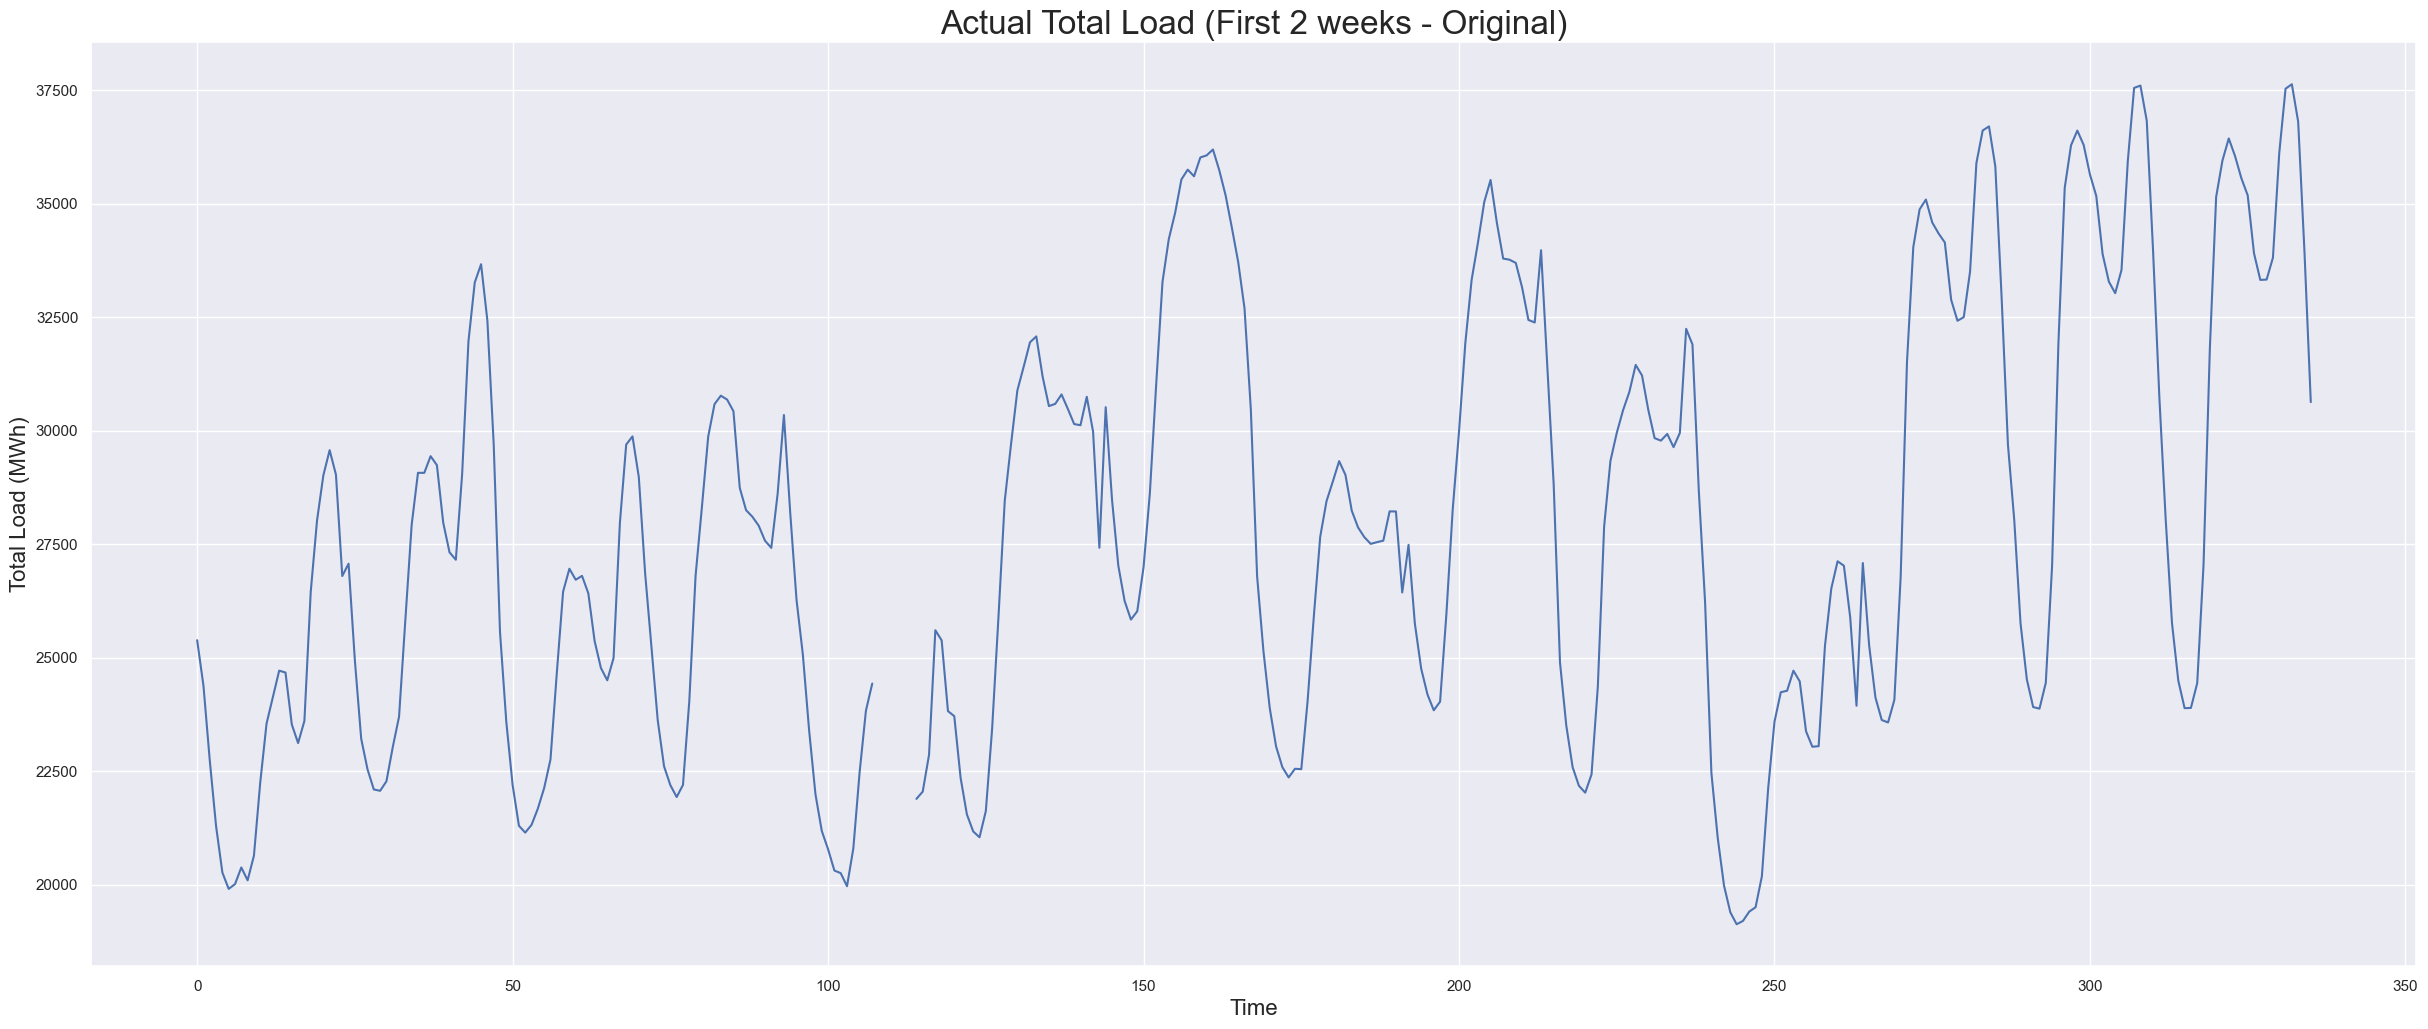

In [10]:
# Function to plot different time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

After zooming into the first 2 weeks of the 'total load actual' column, we observe that there are a few null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs appropriately.

In [11]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

time  generation biomass  \
16612  2016-11-23 04:00:00+01:00                 NaN   
25164  2017-11-14 12:00:00+01:00                 0.0   
25171  2017-11-14 19:00:00+01:00                 0.0   
30185  2018-06-11 18:00:00+02:00               331.0   
30896  2018-07-11 09:00:00+02:00                 NaN   

       generation fossil brown coal/lignite  generation fossil gas  \
16612                                 900.0                 4838.0   
25164                                   0.0                10064.0   
25171                                   0.0                12336.0   
30185                                 506.0                 7538.0   
30896                                   NaN                    NaN   

       generation fossil hard coal  generation fossil oil  \
16612                       4547.0                  269.0   
25164                          0.0                    0.0   
25171                          0.0                    0.0   
30185                       5360.0                  300.0   
30896                          NaN                    NaN   

       generation hydro pumped storage consumption  \
16612                                       1413.0   
25164                                          0.0   
25171                                          0.0   
30185                                          1.0   
30896                                          NaN   

       generation hydro run-of-river and poundage  \
16612                                       795.0   
25164                                         0.0   
25171                                         0.0   
30185                                      1134.0   
30896                                         NaN   

       generation hydro water reservoir  generation nuclear  generation other  \
16612                             435.0              5040.0              60.0   
25164                               0.0                 0.0               0.0   
25171                               0.0                 0.0               0.0   
30185                            4258.0              5856.0              52.0   
30896                               NaN                 NaN               NaN   

       generation other renewable  generation solar  generation waste  \
16612                        85.0              15.0             227.0   
25164                         0.0               0.0               0.0   
25171                         0.0               0.0               0.0   
30185                        96.0             170.0             269.0   
30896                         NaN               NaN               NaN   

       generation wind onshore  total load actual  price day ahead  \
16612                   4598.0            23112.0            43.19   
25164                      0.0                NaN            60.53   
25171                      0.0                NaN            68.05   
30185                   9165.0                NaN            69.87   
30896                      NaN                NaN            63.01   

       price actual  
16612         49.11  
25164         66.17  
25171         75.45  
30185         64.93  
30896         69.79

The null values in the columns which have to do with the type of energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well. In order to handle the null values in `df_energy`, we will use a linear interpolation with a forward direction.

In [12]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3112\66405491.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


In [13]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

time                                           35064
generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


Now that `df_energy` has been cleaned successfully and is ready for further use as input into our model.

## Weather features data

In [14]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [15]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

Here, we can see that all columns of `df_weather` have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. The most important thing to notice is that there are some **problems** and **outliers**. In particular:
- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface . This cannot be the case here.
- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado , a F5 (the largest intensity of the Fujita scale) tornado . A tornado of such intensity has not been recorded in Spain and hopefully will not happen in the future as well. 
- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'.

In [16]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

We have to change the type of some of the columns, so that all of them are float64. We also have to rename it as 'time' so that it matches with the index of `df_energy`.

In [17]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [18]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

C:\Users\Admin\AppData\Local\Temp\ipykernel_3112\2189753010.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)


We have to **split** the `df_weather` dataset into 5 datasets, **one for each different city** (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).

In [19]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city_name')[['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id']].mean()
mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [20]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


It seems that `df_weather` has a lot of *duplicate values*. However, **the method above may also show us rows which have the exame same values**. This is not what we are looking for. What we want to ensure, is that **there are no duplicate index rows**, i.e. that we do not have multiple rows **for the exact same hour**. Of course, we also have to make sure that these duplicates concern **each individual city**. Since, `df_weather` contains information about 5 different cities, it is very useful to display the number of observations for each one and compare it with the size of `df_energy`.

In [21]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


The two dataframes (`df_energy` and `df_weather`) cannot be merged yet. There are many duplicates for every city in `df_weather` and we should drop them and see if their number of rows match. We do this by resetting the index, keeping only the **first rows** which have the same 'time' and 'city_name' values and then setting again 'time' as the index. For further research on the dataset, let us also create a second dataframe, `df_weather_2` in which we do the same procedure, but keep only the **last rows** which have the same 'time' and 'city_name'.

In [22]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], 
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [23]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))
cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [24]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [25]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [26]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

In [27]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

 To calculate and display the R-squared score between the same column in two different DataFrames. The R² score is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. In this context, it helps understand how similar the data in the same column of two DataFrames is, in terms of variance explained.

In [28]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in `df_weather`. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that **the R² values of these two are not comparable** because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the *Levenshtein distance*, i.e. the number of edits required to transform string A to string B. In this case, even this metric would not be enough in order to make 'weather_main' and 'weather_description' comparable as the former contains only single words while the latter large phrases which describe the weather.

In [29]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

We have to emphasize that the method we employed above in order to check the consistency of our dataset is not 100% accurate. This is because it compares two dataframes from which we have cleaned the duplicates in **only two ways exclusively**; keeping the first rows and keeping the last rows of the duplicates. Nevertheless, it gives good results and can be used to check the values of the other columns as well. We should not that since we removed the duplicates based on all the columns except 'time' and 'city_name', there is no point in checking the latter.

In [30]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


In [31]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], 
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


Before proceeding to the next step, i.e. merging `df_energy` and `df_weather`, we also want to treat the outliers which we found earlier in 'pressure' and 'wind_speed'. We will visualize the outliers in these columns using boxplot, change their values to NaNs and then use a linear interpolation in order to replace their values.

## Checking for outliers

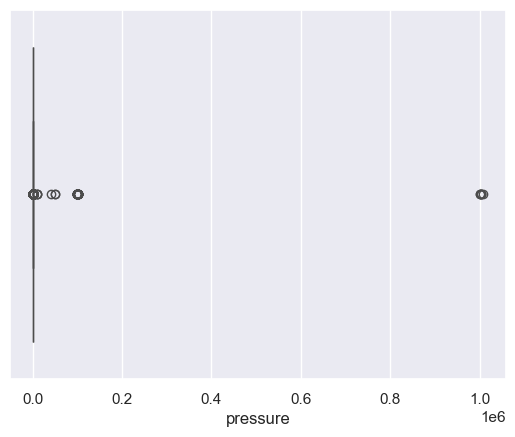

In [32]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

Even a pressure of approximately 100,000 HPa or 10 MPa, which is clearly visible in the above figure, corresponds to a quantity greater than the atmospheric pressure of Venus. In order to be sure, we will set as **NaN** every value in the 'pressure' column which is **higher than 1051 hPa**, which is just above the highest air pressure ever recorded in the Iberian peninsula. While outliers on the low side are not visible in the boxplot above, it is a good idea to also replace the values which are **lower than 931 hPa**, i.e. the lowest air pressure ever recorded in the Iberian peninsula.

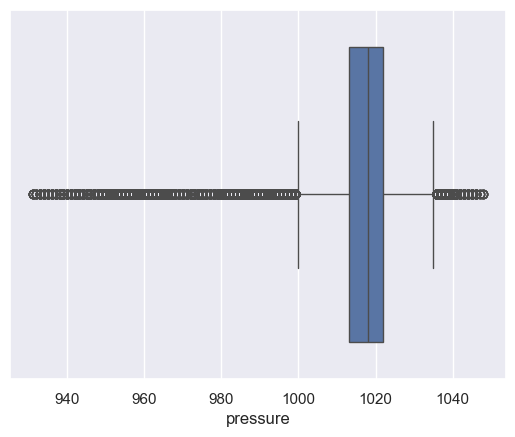

In [33]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

# Check for outliers in 'pressure' column again
df_weather_reset = df_weather.reset_index(drop=True)

# Use the DataFrame with the reset index for plotting
sns.boxplot(x=df_weather_reset['pressure'])
plt.show()

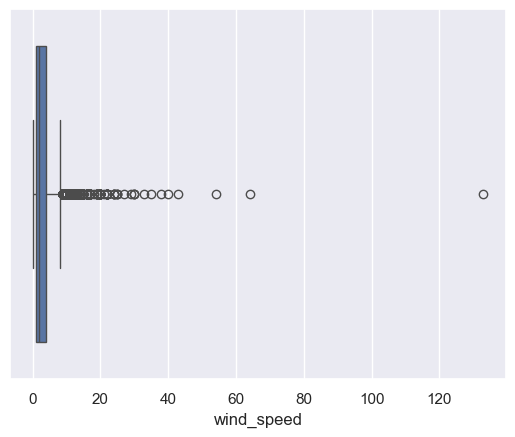

In [34]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

Here, we will follow a conservative approach as above. We will set as **NaNs** the values in 'wind_speed' which are **higher than 50 m/s**, which is the highest bound (112 mph) of the wind speed estimate of a F1 (Fujita scale) tornado, having in mind that the last F1 tornado in Spain was Gandia tornado, which was recorded on 28th September 2012, i.e. roughly 2 years before the starting point of our available data.

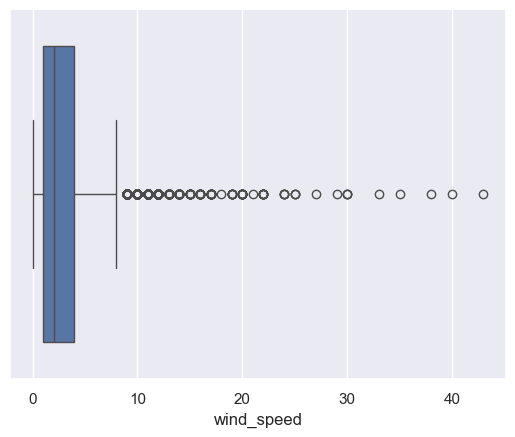

In [35]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan
# Check for outliers in 'wind_speed' column again
df_weather_reset = df_weather.reset_index(drop=True)
sns.boxplot(x=df_weather_reset['wind_speed'])
plt.show()

In [36]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3112\3371874962.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


Everything looks nice and clean and `df_weather` is also ready for use as input to our model. We also have to plot the 'rain_1h' and 'rain_3h' columns, as we have indicated that at least one of them (probably 'rain_3h') is quite problematic. Nevertheless, we will do so after we merge the two datasets.

##  Merging the two datasets

In [37]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [38]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35064 non-null  float64
 2   generation fossil brown coal/lignite         35064 non-null  float64
 3   generation fossil gas                        35064 non-null  float64
 4   generation fossil hard coal                  35064 non-null  float64
 5   generation fossil oil                        35064 non-null  float64
 6   generation hydro pumped storage consumption  35064 non-null  float64
 7   generation hydro run-of-river and poundage   35064 non-null  float64
 8   generation hydro water reservoir             35064 non-null  float64
 9   generation nuclear                           35064 non-null  float64
 10

In [39]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
df_energy.set_index('time', inplace=True)

In [40]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

In [41]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


## Visualizations

Before anything else, we will check the 'rain_1h' and 'rain_3h' columns for a specific city.

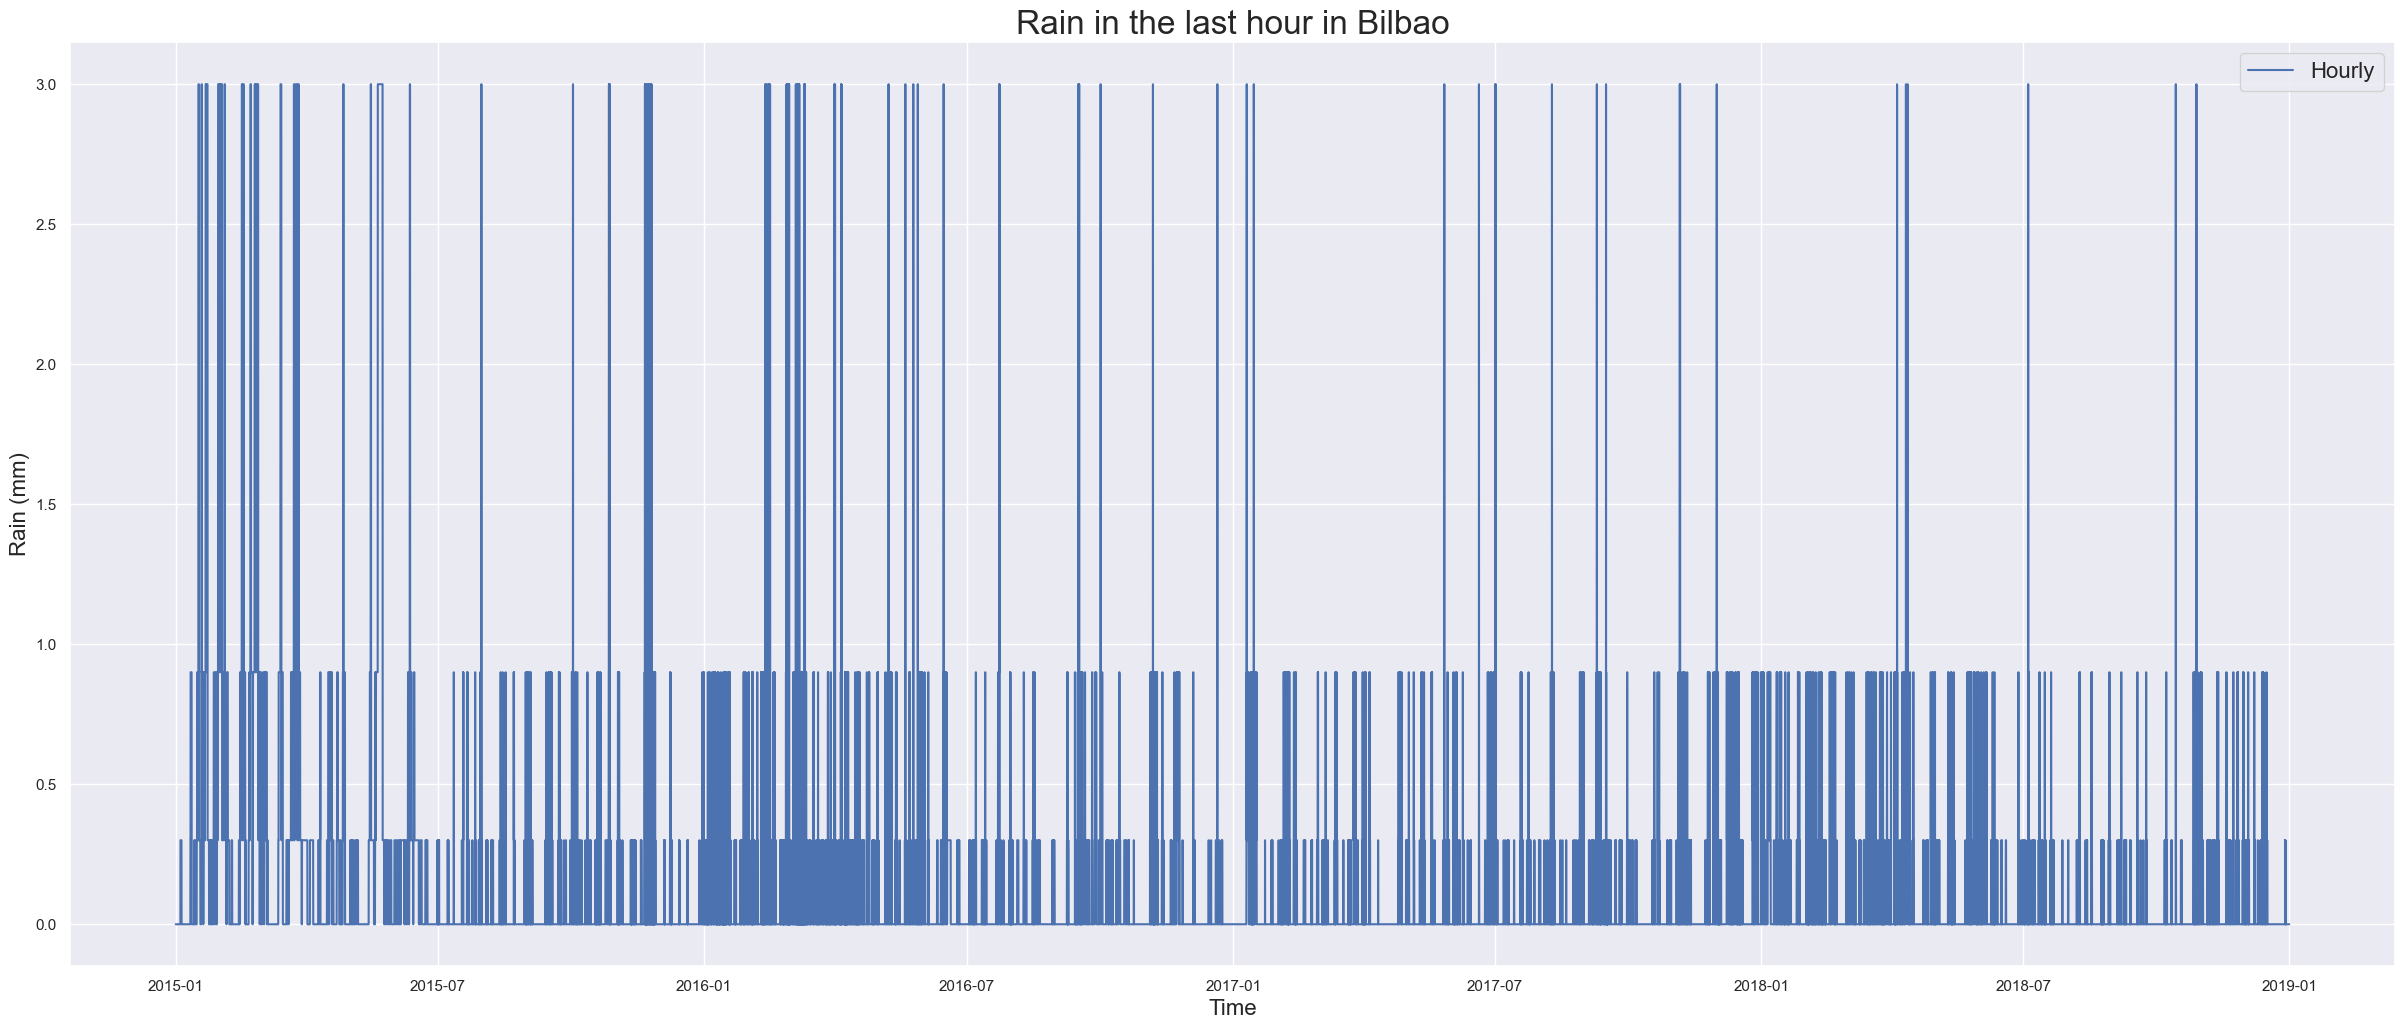

In [42]:
# Plot the 'rain_1h' for Bilbao

ax = plot_series(df_final, 'rain_1h_Bilbao', 
                 label='Hourly', ylabel='Rain (mm)',
                 title='Rain in the last hour in Bilbao')
plt.show()

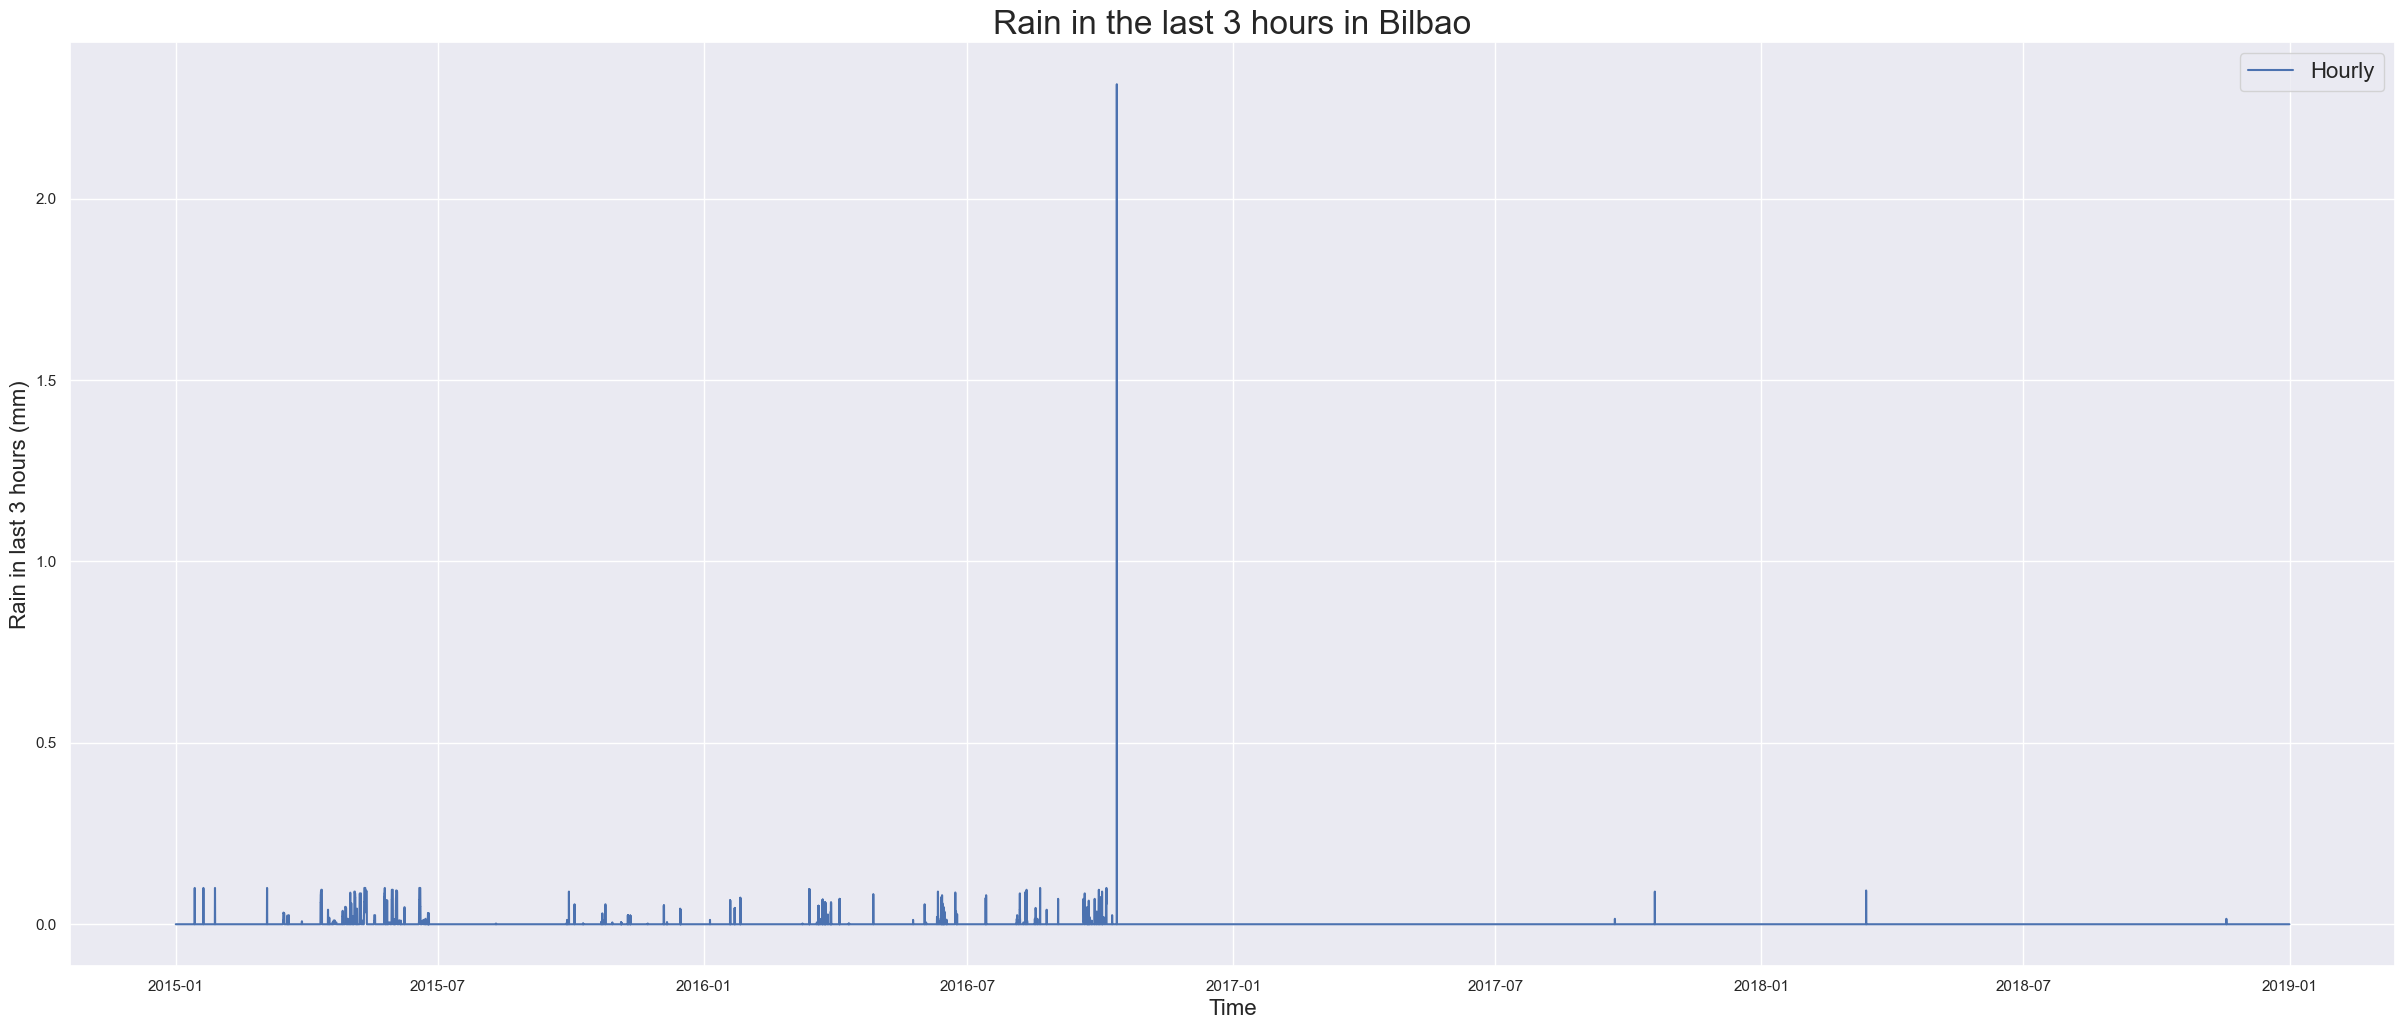

In [43]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

From the two figures above, we can conclude that **'rain_3h' is an unreliable feature which will drop from the dataset**.

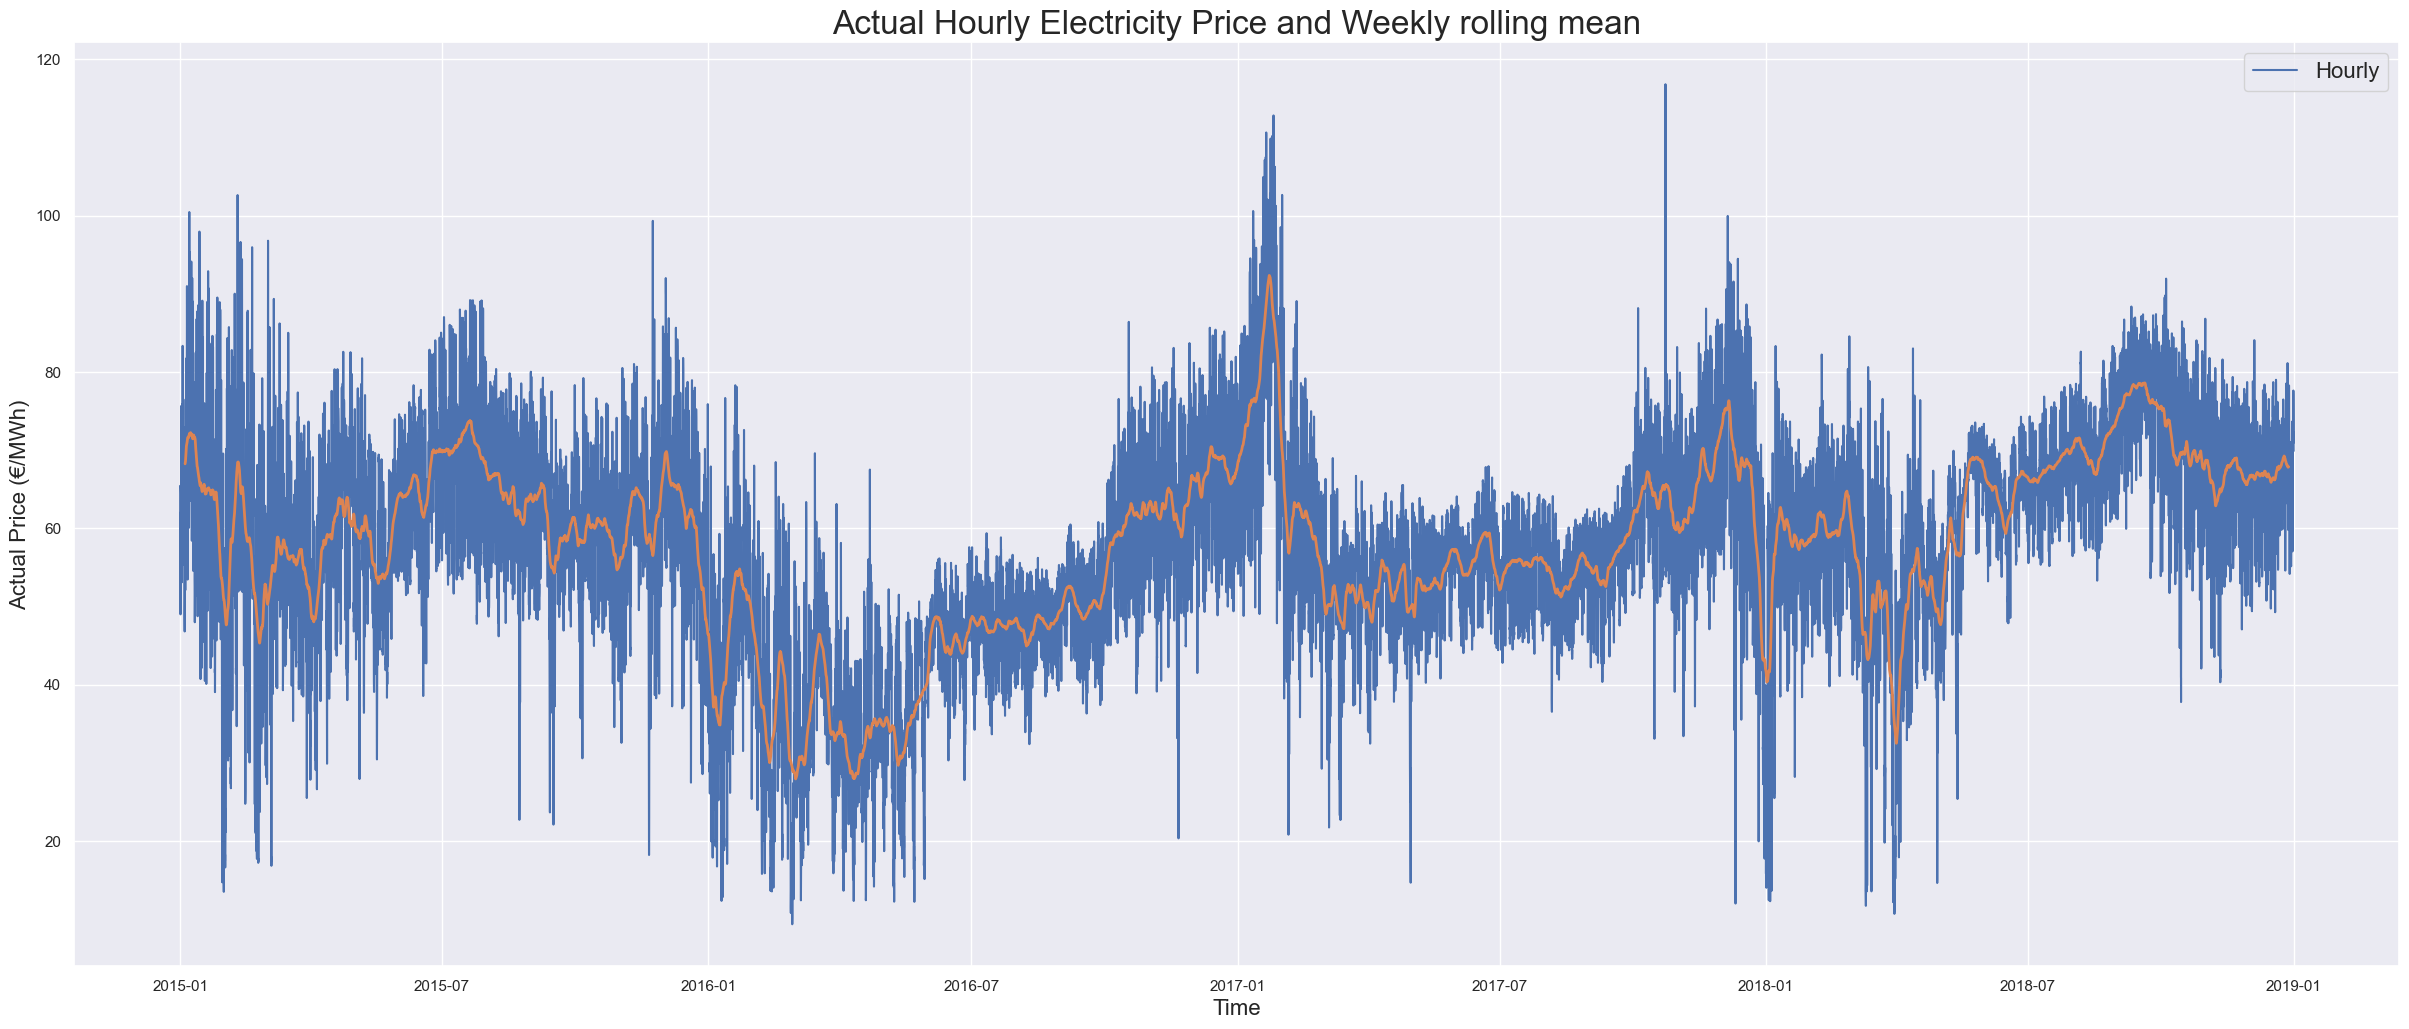

In [44]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_3112\3487247313.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_price = df_final['price actual'].asfreq('M')
C:\Users\Admin\AppData\Local\Temp\ipykernel_3112\3487247313.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  shifted = df_final['price actual'].asfreq('M').shift(12)


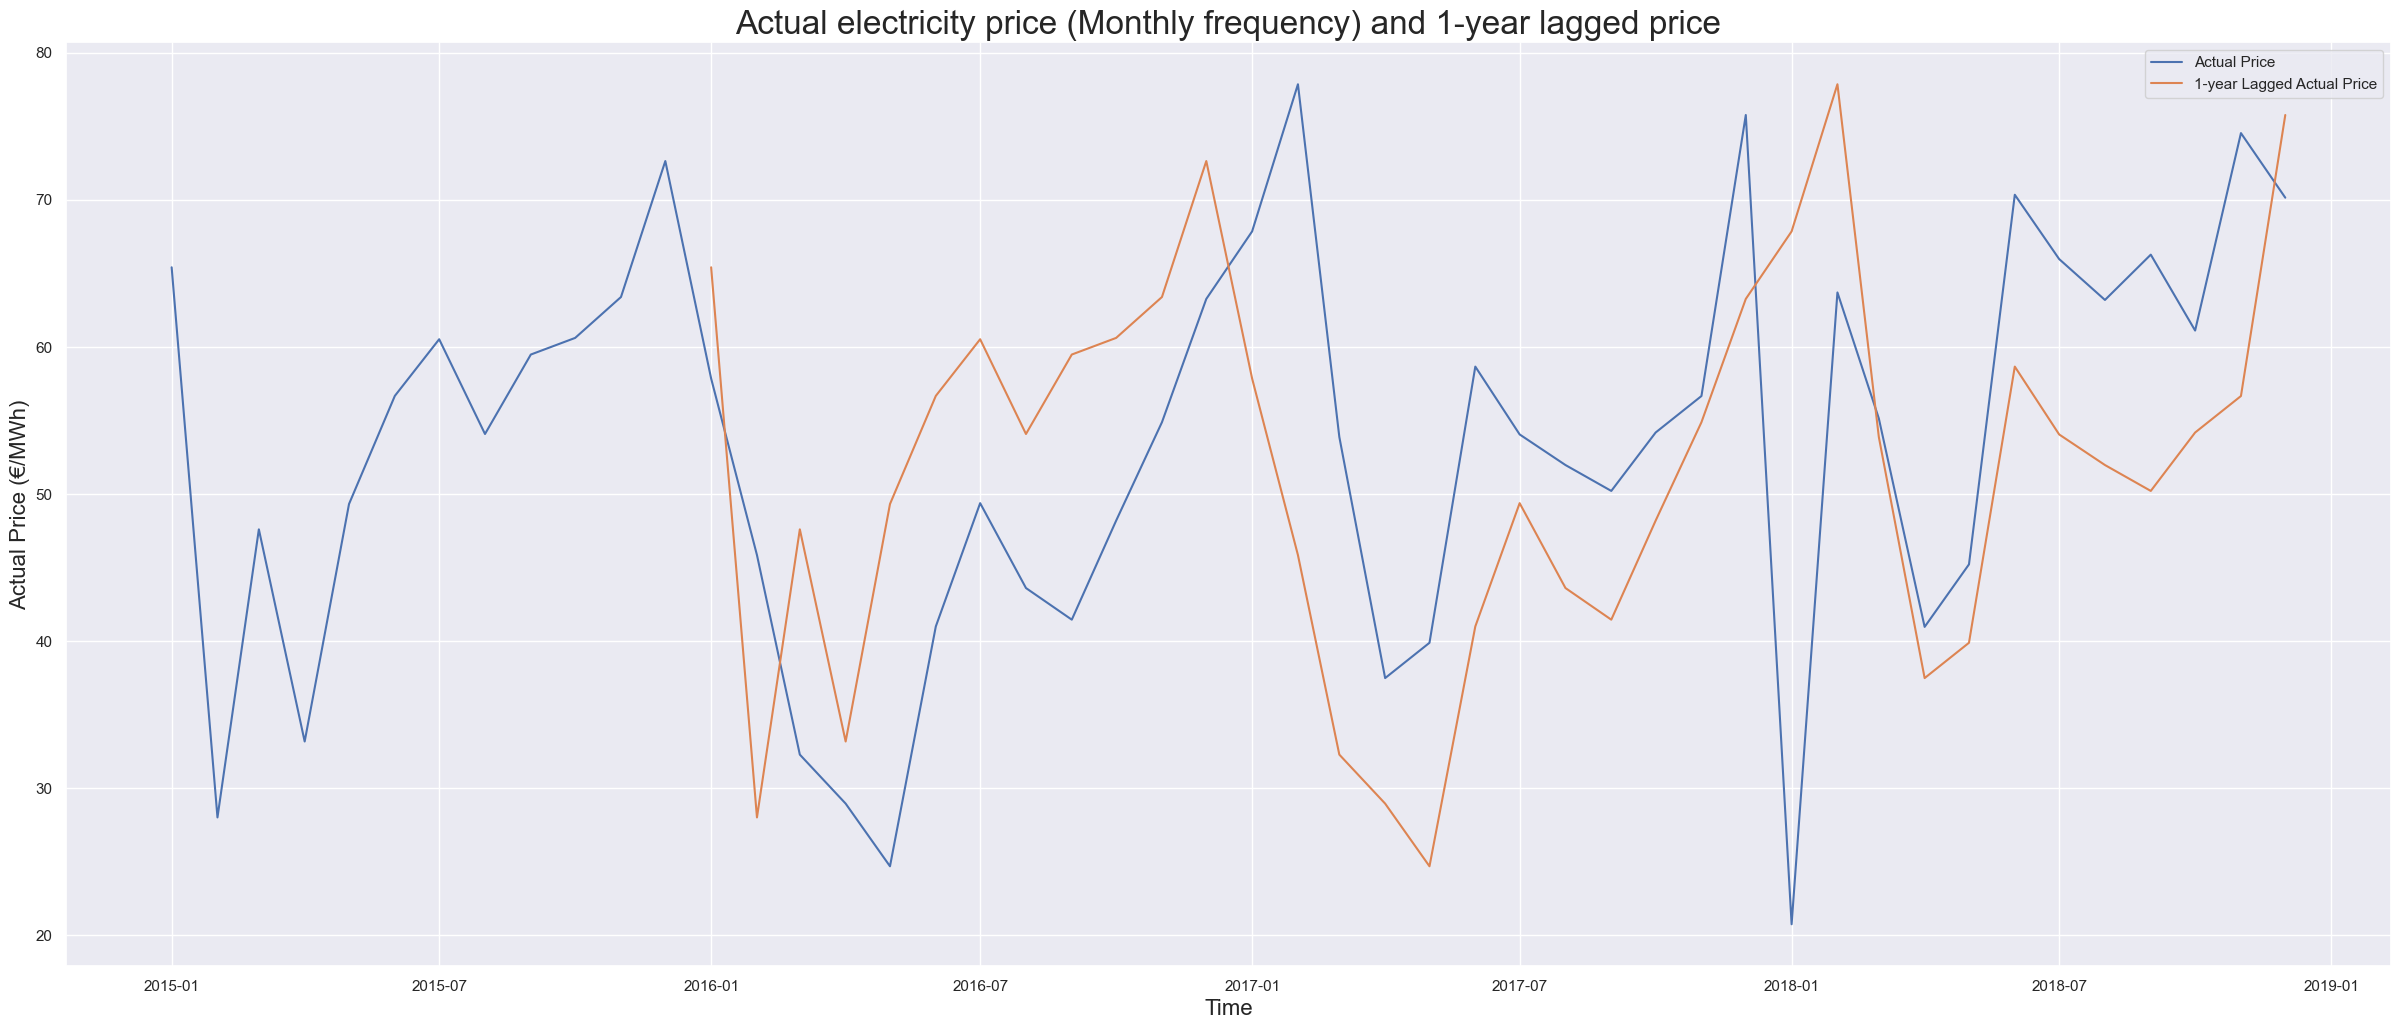

In [45]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed **seasonal patterns at the monthly scale**, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

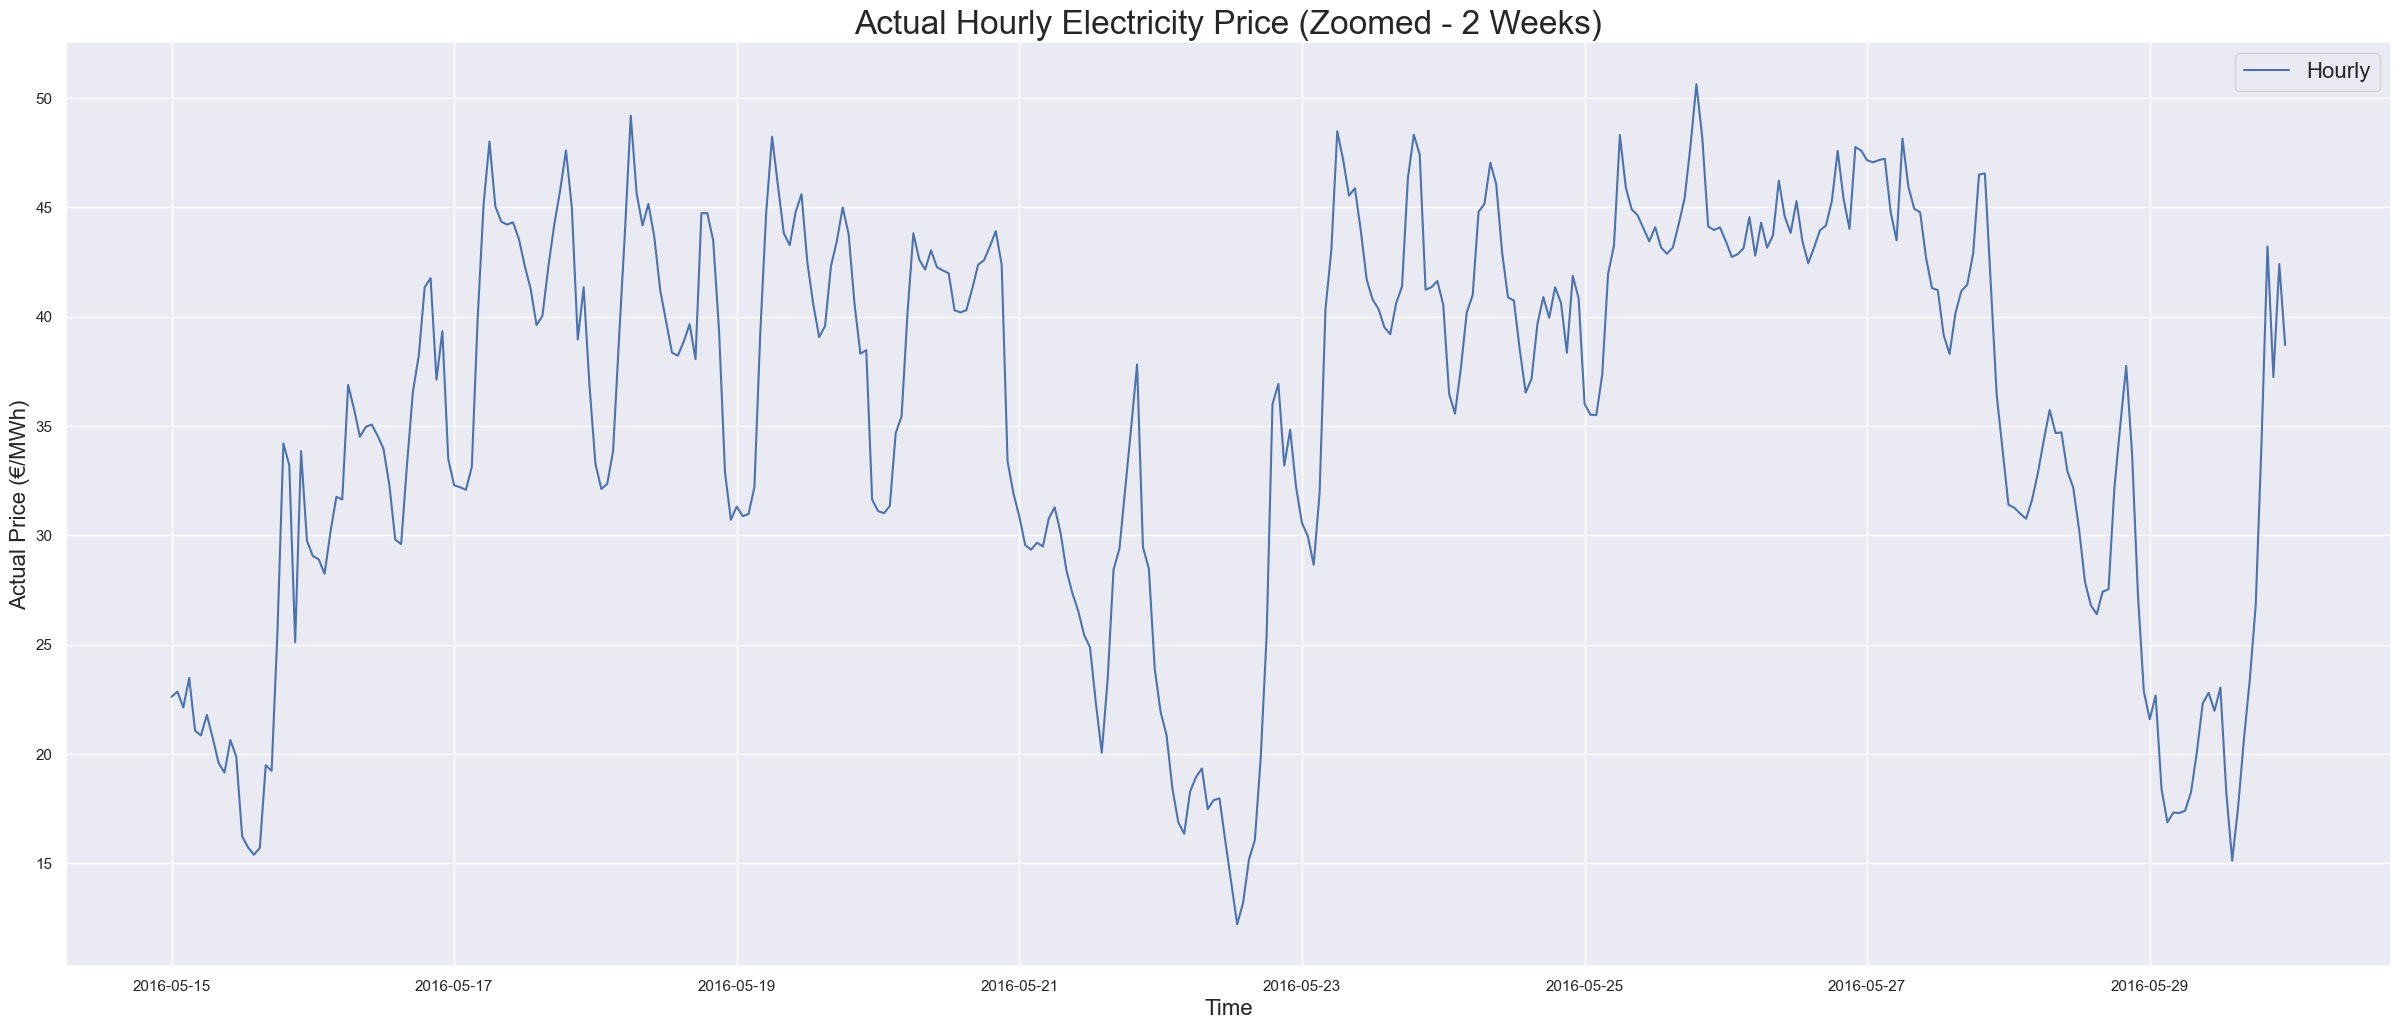

In [46]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted that actual hourly electricity price from 15/06/2016 (Sunday) at 00:00 up to 29/06/2016 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:
- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
- An intradyay periodicity, as the price is higher during the day and lower during the night.
- A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to "siesta", the traditional lunch break between 01:30PM and 04:30PM, as Spain does not strictly follow the 9AM-5PM business day.

Later on, we will make sure that we will generate features which contain these kinds of information.

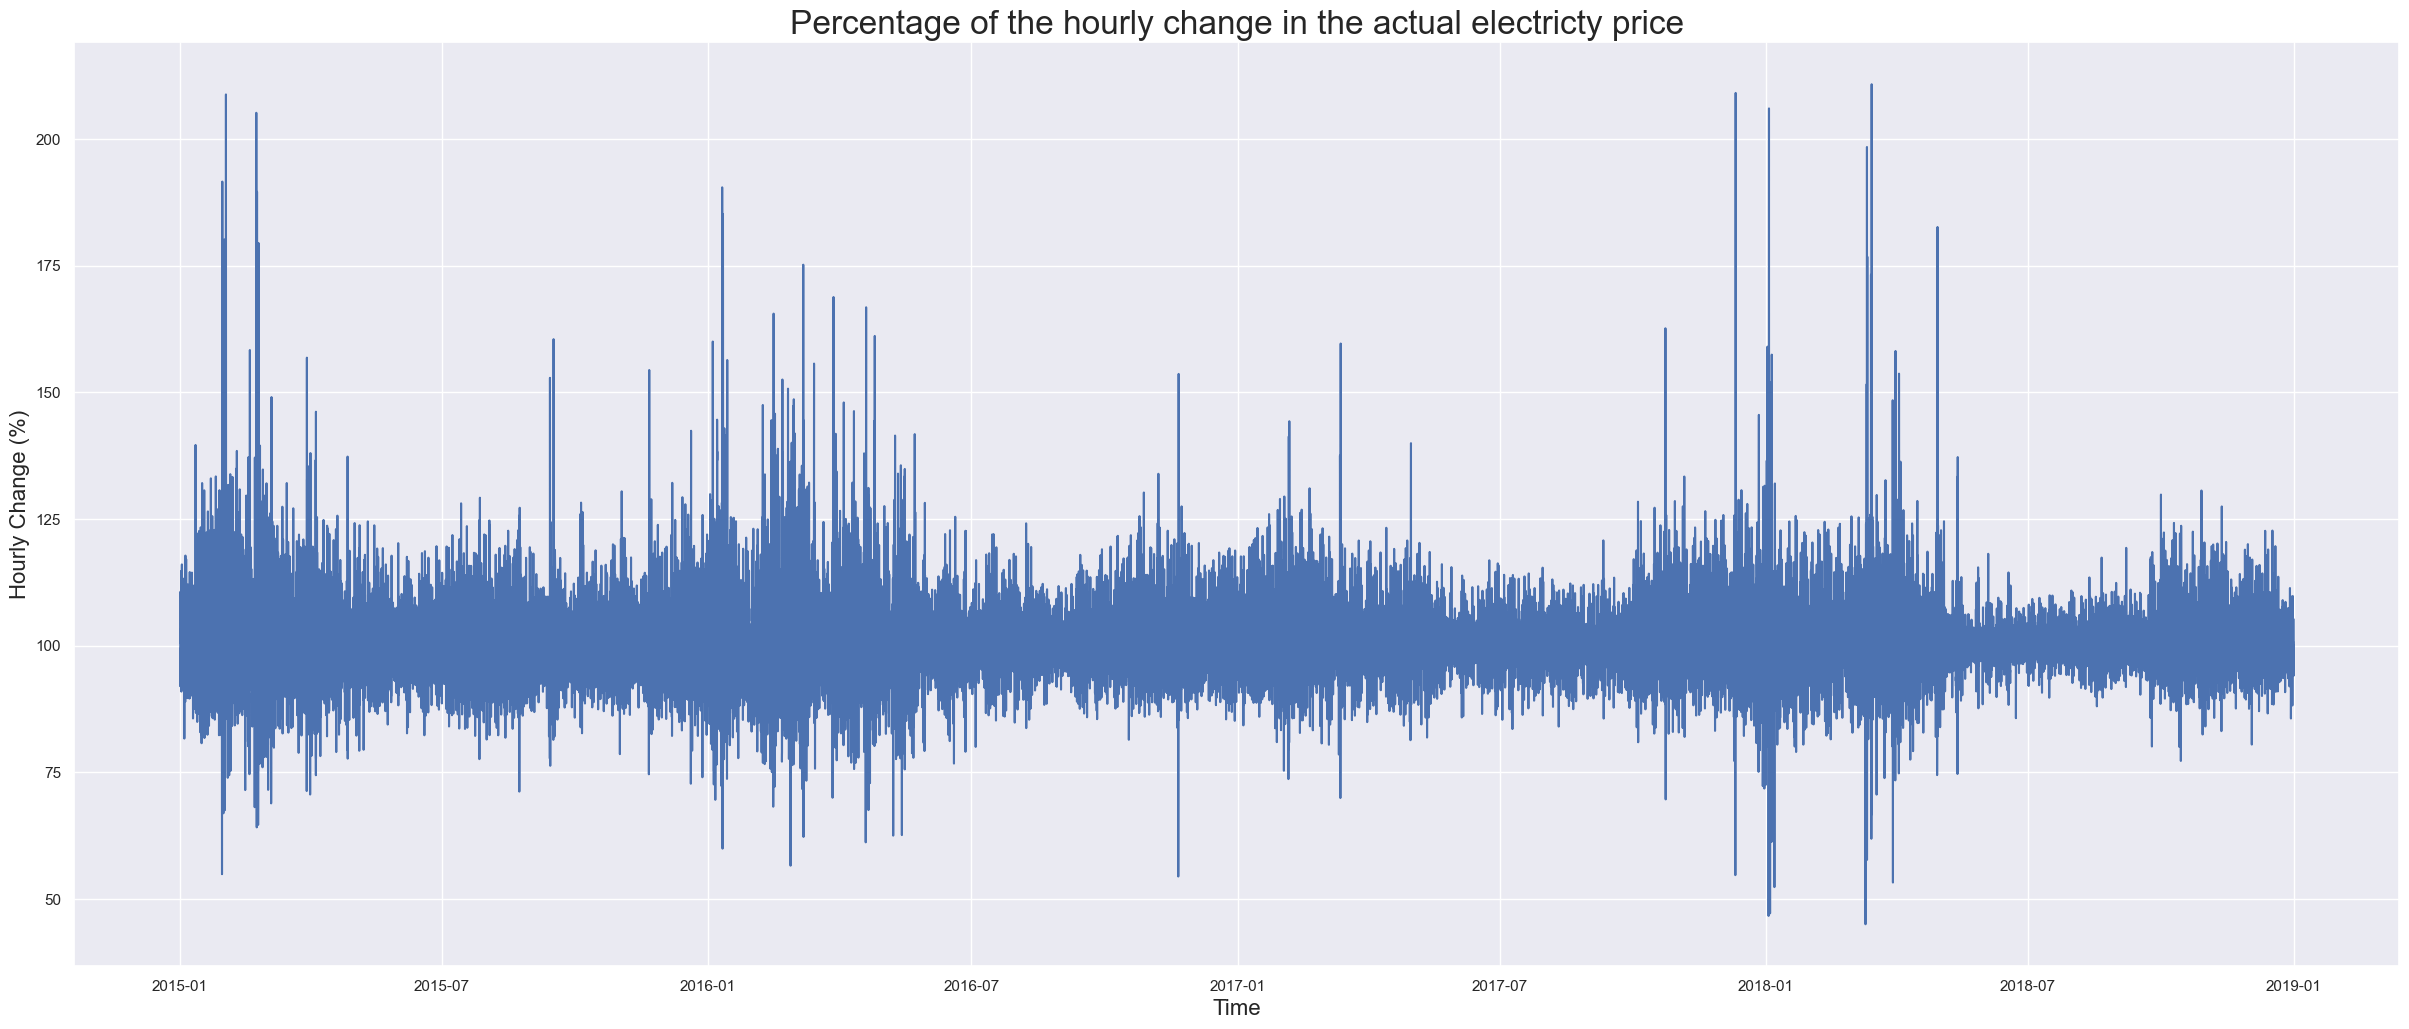

In [47]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price \* 0.75) and +25% (actual price \* 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

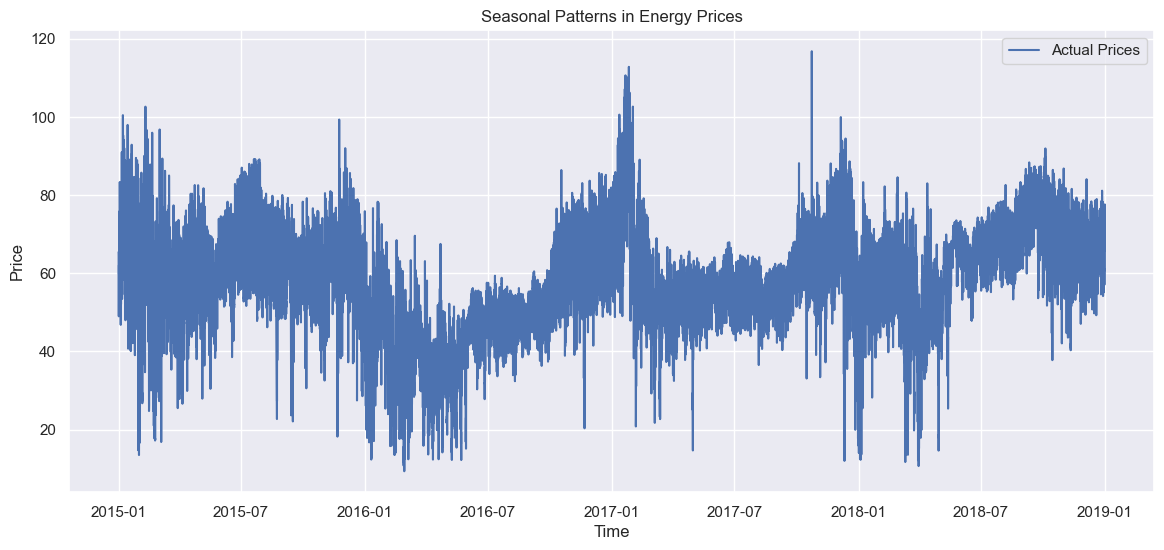

In [48]:
# Analyzing Seasonal Patterns in Energy Prices
plt.figure(figsize=(14, 6))
plt.plot(df_final.index, df_final['price actual'], label='Actual Prices')
plt.title('Seasonal Patterns in Energy Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

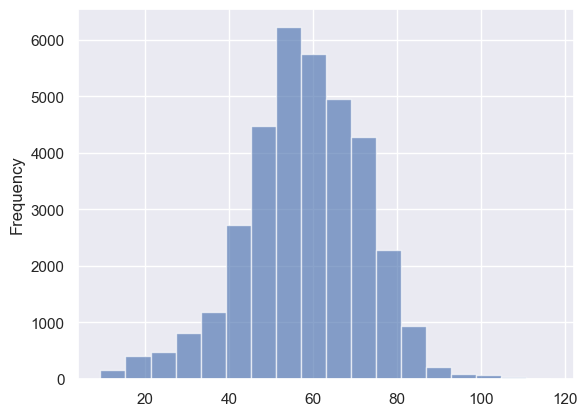

In [49]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy price roughly follows a normal distribution and thus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series. 

In [50]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

In [51]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

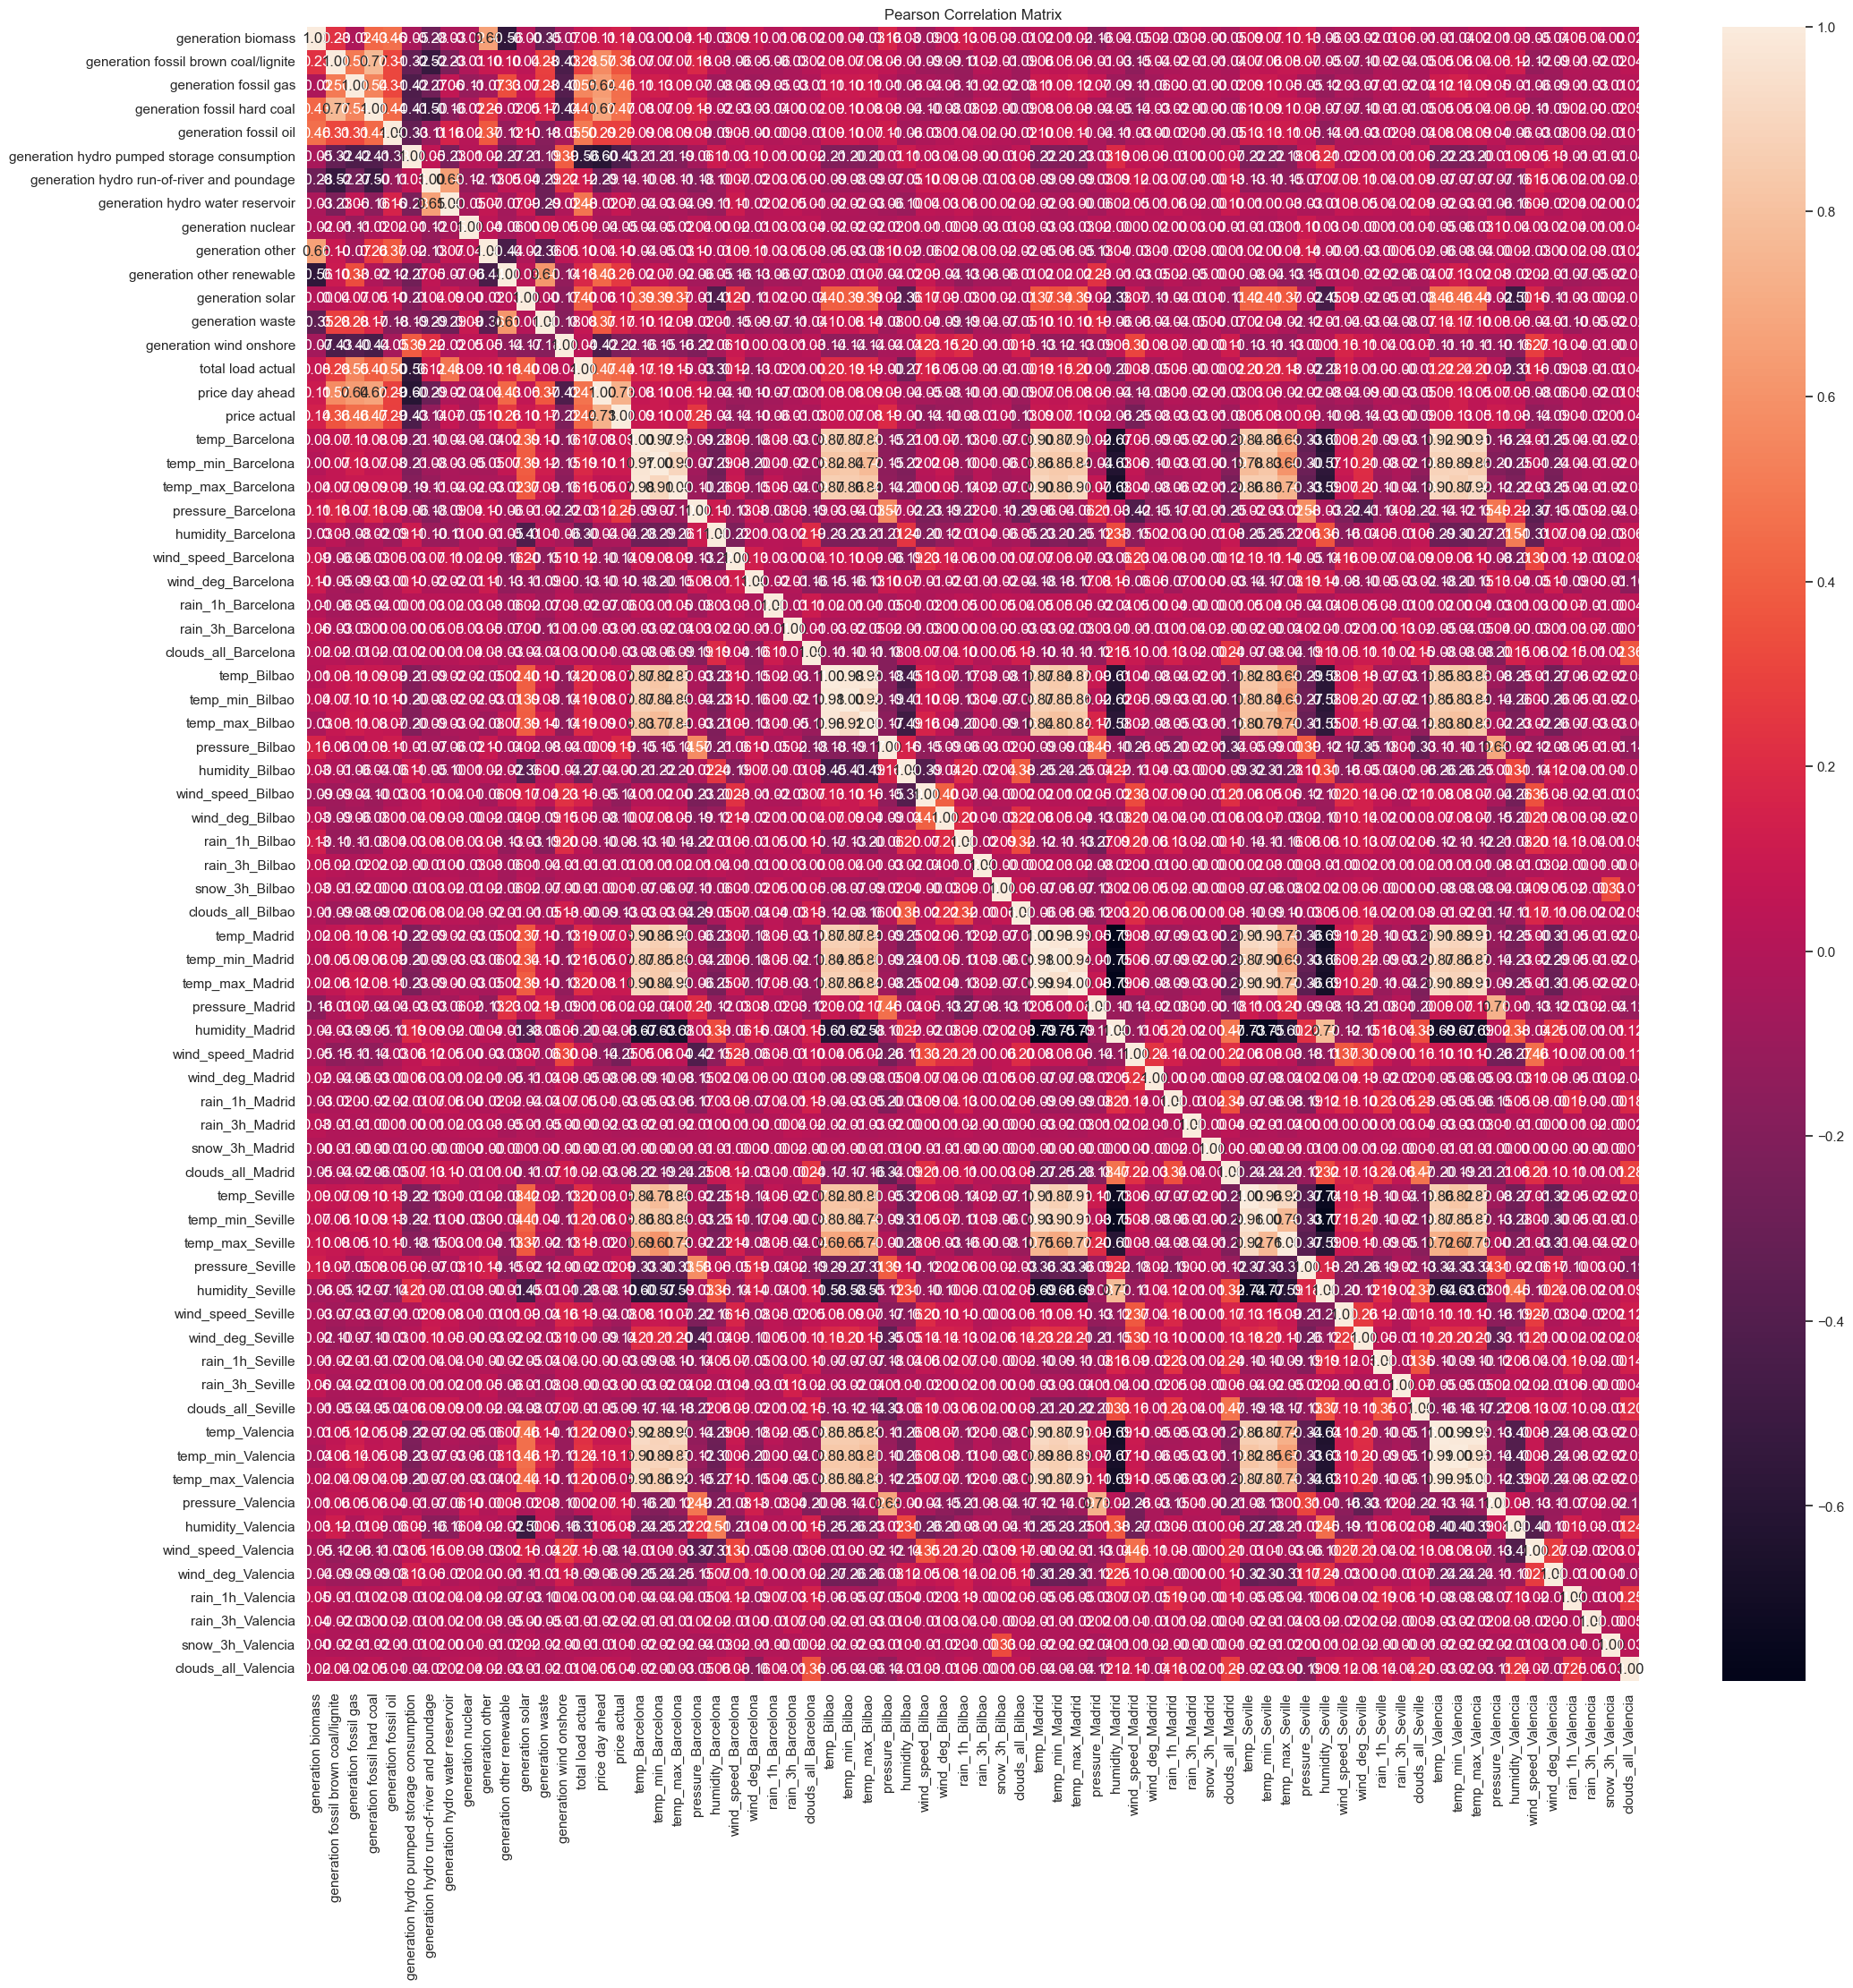

In [52]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [53]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).

## Feature Engineering

The first features that we will generate for a given hour will just be that particular hour, the day and the month in which it falls into.

In [54]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Spain as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break (known as "siesta") in between. The most usual business hours are from Monday-Saturday, from 9:30AM-1:30PM and then again from 4:30PM-8PM.

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the "siesta" in between and equal to '0' for all other given hours.

In [55]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

However, we have generated the 'business hour' feature in such a way which also includes weekends, on which fewer -or different types of- businesses are open. Thus, it is useful to also generate another feature, 'weekend', which will distuingish weekdays and weekends, as well as make a distinction between Saturdays and Sundays.

In particular, for a particular given hour, the value of 'weekend' will be equal to '0', if the hours is in a weekday, equal to '1' if the hour is in a Saturday and equal to '2' if the hour is in a Sunday.

In [56]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') for each city and we will name that feature 'temp_range_{name of city}'.

In [57]:
df_final.reset_index(drop=False, inplace=True)

df_final.index = pd.to_datetime(df_final['time'], utc=True, infer_datetime_format=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3112\2406258132.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_final.index = pd.to_datetime(df_final['time'], utc=True, infer_datetime_format=True)


In [58]:
df_final.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'rain_3h_Bilbao', 'snow_3h_Bilbao',
       'clouds_all_Bilba

Drop other columns that seem to create noise for our models

In [59]:
columns_to_drop = [
'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona', 'rain_3h_Barcelona','temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao', 'rain_3h_Bilbao', 'snow_3h_Bilbao', 'temp_min_Madrid', 'temp_max_Madrid', 'pressure_Madrid', 'humidity_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid', 'rain_3h_Madrid', 'snow_3h_Madrid', 'temp_min_Seville', 'temp_max_Seville', 'pressure_Seville', 'humidity_Seville', 'wind_deg_Seville', 'rain_1h_Seville', 'rain_3h_Seville','temp_min_Valencia', 'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia','wind_deg_Valencia', 'rain_1h_Valencia', 'rain_3h_Valencia', 'snow_3h_Valencia','price day ahead'
]
# Assuming df_final is your dataframe
df_final_lean = df_final.drop(columns=columns_to_drop)

df_final_lean.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price actual', 'temp_Barcelona', 'wind_speed_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'wind_speed_Bilbao',
       'clouds_all_Bilbao', 'temp_Madrid', 'wind_speed_Madrid',
       'clouds_all_Madrid', 'temp_Seville', 'wind_speed_Seville',
       'clouds_all_Seville', 'temp_Valencia', 'wind_speed_Valencia',
       'clouds_all_Valencia', 'hour', 'weekday', 'month', 'business hour'],
      dtype='object')

## More Visuals

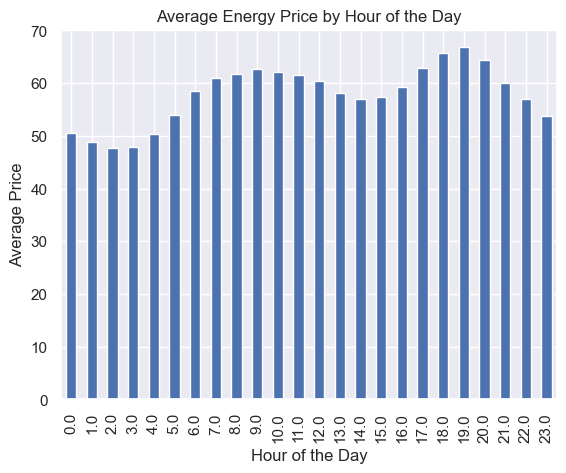

In [60]:
# Average energy price by hour of the day
df_final_lean.groupby('hour')['price actual'].mean().plot(kind='bar')
plt.title('Average Energy Price by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Price')
plt.show()

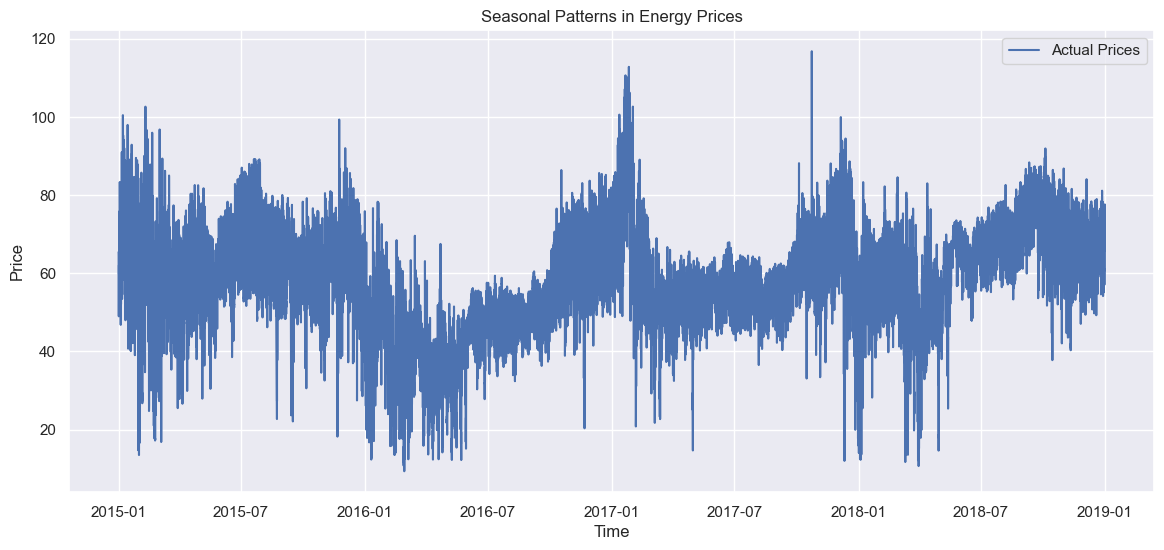

In [61]:
# Analyzing Seasonal Patterns in Energy Prices
plt.figure(figsize=(14, 6))
plt.plot(df_final_lean.index, df_final_lean['price actual'], label='Actual Prices')
plt.title('Seasonal Patterns in Energy Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Time Series

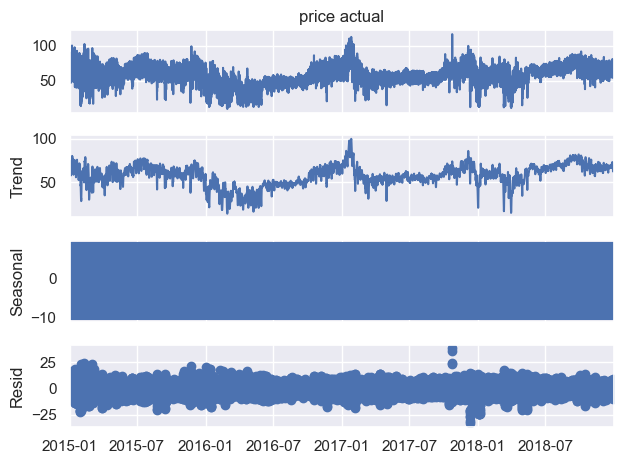

In [62]:
# Seasonal decomposition to understand trends, seasonality, and residuals in energy prices
result = seasonal_decompose(df_final_lean['price actual'], model='additive', period=24)  # assuming hourly data
result.plot()
plt.show()

ADF Statistic: -9.147016232851161
p-value: 2.7504934849347068e-15


<Figure size 1400x700 with 0 Axes>

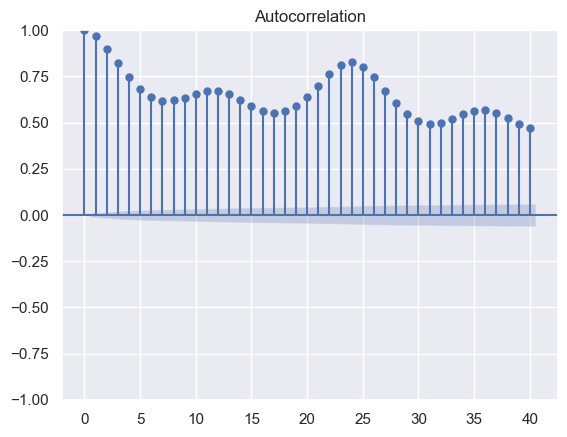

<Figure size 1400x700 with 0 Axes>

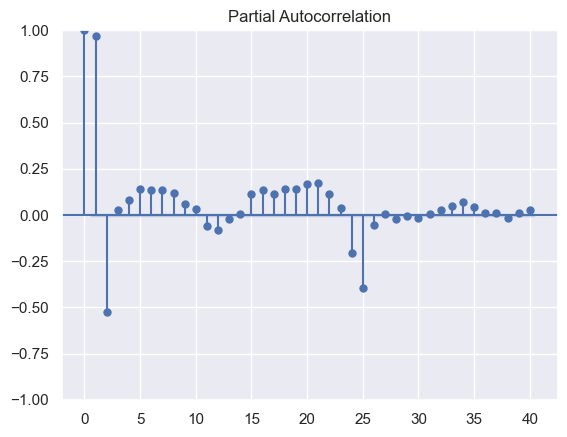

In [63]:
# Assuming 'y' is your time series data
y = df_final_lean['price actual']

# Check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(y)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If the p-value is high, consider differencing the data
# y_diff = y.diff().dropna()

# Plot ACF
plt.figure(figsize=(14,7))
plot_acf(y, lags=40)  # Adjust lags as needed
plt.show()

# Plot PACF
plt.figure(figsize=(14,7))
plot_pacf(y, lags=40)  # Adjust lags as needed
plt.show()

The autocorrelation and partial autocorrelation plots, along with the Augmented Dickey-Fuller (ADF) test results, provide more insights into the time series.

1. Autocorrelation Function (ACF) Plot: The ACF plot shows a slow decay in correlation coefficients as the lag increases, which is typical of a time series with a strong trend or long memory process. The pattern of spikes at regular intervals suggests seasonality in the data.

2. Partial Autocorrelation Function (PACF) Plot: The PACF plot shows a significant spike at lag 1, and then it mostly falls within the confidence interval (which is usually set at 95%, corresponding to the significance level of 0.05). This indicates that there is one significant lag, after which the partial autocorrelations are not significant.

3. ADF Test Results: The ADF test is used to test for the presence of unit root in a time series (i.e., to test if the series is non-stationary). The test statistic of -9.147 is more negative than the typical critical values for the ADF test (e.g., -3.5, -2.9, -2.6 at the 1%, 5%, and 10% significance levels), and the very small p-value suggests that the null hypothesis of a unit root can be rejected with strong confidence. This means that the time series is stationary.

Given these analyses, here is the summary:

1. The ADF test suggests that the time series is stationary, so you don't need to difference the series to make it stationary for modeling.
2. The ACF indicates that there may be trend or seasonality effects that need to be captured by the model, or that there is a long memory process at play.
3. The PACF suggests that an autoregressive term of order 1 might be significant when modeling this time series.

In [64]:
df_final_lean["time"].tail()

time
2018-12-31 18:00:00+00:00   2018-12-31 18:00:00+00:00
2018-12-31 19:00:00+00:00   2018-12-31 19:00:00+00:00
2018-12-31 20:00:00+00:00   2018-12-31 20:00:00+00:00
2018-12-31 21:00:00+00:00   2018-12-31 21:00:00+00:00
2018-12-31 22:00:00+00:00   2018-12-31 22:00:00+00:00
Name: time, dtype: datetime64[ns, UTC]

In [65]:
df_time = df_final_lean.copy()
df_ml = df_final_lean.copy()
df_backup = df_time.copy()

In [66]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil gas                        35064 non-null  float64            
 4   generation fossil hard coal                  35064 non-null  float64            
 5   generation fossil oil                        35064 non-null  float64            
 6   generation hydro pumped storage consumption  35064 non-null  float64            
 7   generation hydro run-of-river and poundage   35064 non-null  floa

Lag Features and Rolling Windows

In [67]:
# Create lagged features for 'price actual'
for lag in range(1, 49):  # This creates lags from 1 to 48 hours
    df_time[f'price_lag_{lag}'] = df_time['price actual'].shift(lag)

# Create rolling window features (mean and std deviation) for 'price actual'
rolling_windows = [24]  # 24-hour rolling window
for window in rolling_windows:
    df_time[f'price_rolling_mean_{window}'] = df_time['price actual'].rolling(window=window).mean()
    df_time[f'price_rolling_std_{window}'] = df_time['price actual'].rolling(window=window).std()

# Drop the first 48 rows which will have NaN values due to lagging
df_time = df_time.dropna()

In [68]:
df_time.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price actual', 'temp_Barcelona', 'wind_speed_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'wind_speed_Bilbao',
       'clouds_all_Bilbao', 'temp_Madrid', 'wind_speed_Madrid',
       'clouds_all_Madrid', 'temp_Seville', 'wind_speed_Seville',
       'clouds_all_Seville', 'temp_Valencia', 'wind_speed_Valencia',
       'clouds_all_Valencia', 'hour', 'weekday', 'month', 'business hour',
       'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4',
       'price_lag_5', 'price_lag_6', '

Time Series Splitting

In [69]:
# Assuming df_time is your DataFrame and 'price actual' is the target variable
X = np.array(df_time.drop(columns=['price actual']))  # Features array
y = np.array(df_time['price actual'])  # Target variable array

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Example: Iterate through train-test splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [70]:

# Determine the number of observations to split off for the test set
n_test = 24

# Split the data into train and test sets
train = df_time.iloc[:-n_test, :]
test = df_time.iloc[-n_test:, :]

# The 'price actual' column will be used to fit the ARIMA model
arima_train = train['price actual']

# Fit the ARIMA model (using p=1, d=0, q=1 as an example)
arima_model = ARIMA(arima_train, order=(1, 0, 1))
arima_results = arima_model.fit()

# Fit the SARIMA model (using p=1, d=0, q=1 and seasonal order P=1, D=0, Q=1, s=24 as an example)
sarima_model = SARIMAX(arima_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
sarima_results = sarima_model.fit()

# Forecasting the next 24 hours with ARIMA
arima_forecast = arima_results.get_forecast(steps=24)
arima_forecast_values = arima_forecast.predicted_mean

# Forecasting the next 24 hours with SARIMA
sarima_forecast = sarima_results.get_forecast(steps=24)
sarima_forecast_values = sarima_forecast.predicted_mean

c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

In [71]:
# Predicted mean
arima_forecast_values = arima_forecast.predicted_mean
sarima_forecast_values = sarima_forecast.predicted_mean

# Confidence intervals
arima_conf_int = arima_forecast.conf_int()
sarima_conf_int = sarima_forecast.conf_int()

In [72]:
arima_test = test['price actual']

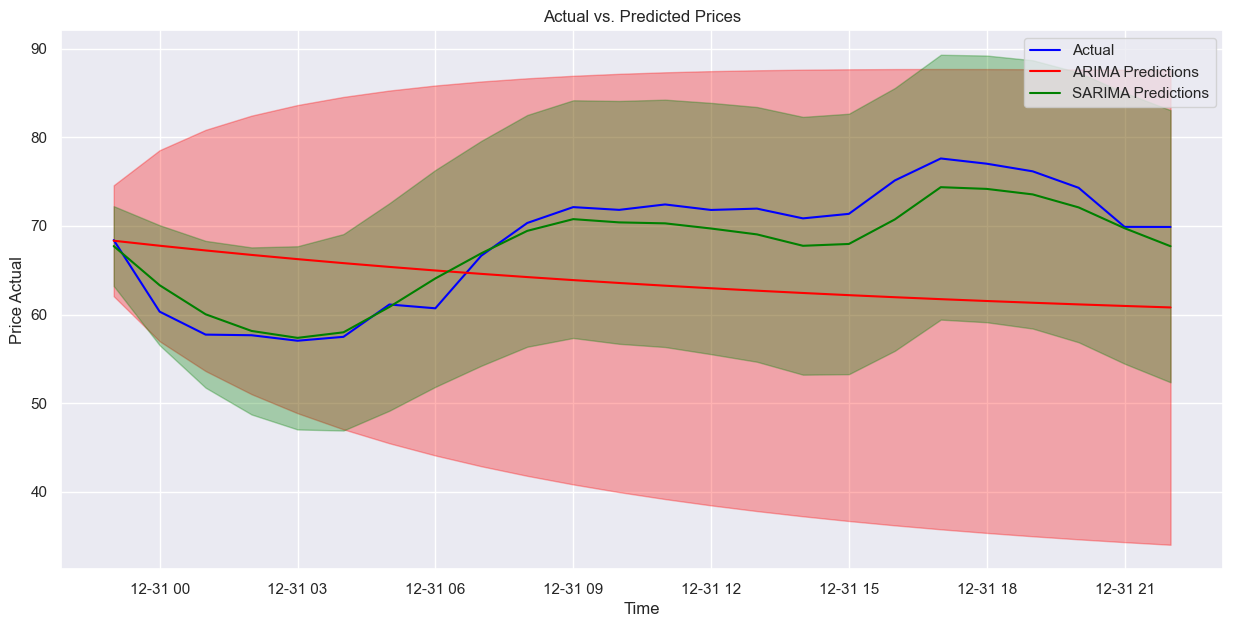

In [73]:
# Plotting the actual vs. predicted values with confidence intervals
plt.figure(figsize=(15, 7))

# Actual values
plt.plot(arima_test.index, arima_test, label='Actual', color='blue')

# ARIMA Predictions
plt.plot(arima_forecast_values.index, arima_forecast_values, label='ARIMA Predictions', color='red')
plt.fill_between(arima_forecast_values.index, 
                 arima_conf_int.iloc[:, 0], 
                 arima_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)

# SARIMA Predictions
plt.plot(sarima_forecast_values.index, sarima_forecast_values, label='SARIMA Predictions', color='green')
plt.fill_between(sarima_forecast_values.index, 
                 sarima_conf_int.iloc[:, 0], 
                 sarima_conf_int.iloc[:, 1], 
                 color='green', alpha=0.3)

plt.title('Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.legend()
plt.show()

In [74]:
# Calculate MAE
arima_mae = mean_absolute_error(arima_test, arima_forecast_values)
sarima_mae = mean_absolute_error(arima_test, sarima_forecast_values)

# Calculate R-squared (R2)
arima_r2 = r2_score(arima_test, arima_forecast_values)
sarima_r2 = r2_score(arima_test, sarima_forecast_values)

# Calculate RMSE
arima_rmse = mean_squared_error(arima_test, arima_forecast_values, squared=False)
sarima_rmse = mean_squared_error(arima_test, sarima_forecast_values, squared=False)

# Calculate MAPE - Mean Absolute Percentage Error function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

arima_mape = mean_absolute_percentage_error(arima_test, arima_forecast_values)
sarima_mape = mean_absolute_percentage_error(arima_test, sarima_forecast_values)

# Display the metrics
print(f"ARIMA Model Metrics:\nMAE: {arima_mae}\nRMSE: {arima_rmse}\nMAPE: {arima_mape}%\nR-squared (R2): {arima_r2}")
print(f"SARIMA Model Metrics:\nMAE: {sarima_mae}\nRMSE: {sarima_rmse}\nMAPE: {sarima_mape}%\nR-squared (R2): {sarima_r2}")

ARIMA Model Metrics:
MAE: 8.841200402348216
RMSE: 9.617369867062244
MAPE: 12.81469252696556%
R-squared (R2): -1.122205226672024
SARIMA Model Metrics:
MAE: 1.9211455521446954
RMSE: 2.2753566740921762
MAPE: 2.759040081913337%
R-squared (R2): 0.8812116879401617


c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


For the ARIMA model:

1. MAE (Mean Absolute Error): The average absolute difference between the predicted and actual values is 8.84 units.
2. RMSE (Root Mean Squared Error): The square root of the average squared differences between the predicted and actual values is 9.62 units.
3. MAPE (Mean Absolute Percentage Error): On average, the absolute percentage difference between the predicted and actual values is 12.81%.
4. R-squared (R2): The coefficient of determination indicates that the model does not explain the variability of the data well, with a negative value of -1.12. This suggests that the model performs poorly in explaining the variance in the data.

For the SARIMA model:

1. MAE (Mean Absolute Error): The average absolute difference between the predicted and actual values is 1.92 units.
2. RMSE (Root Mean Squared Error): The square root of the average squared differences between the predicted and actual values is 2.28 units.
3. MAPE (Mean Absolute Percentage Error): On average, the absolute percentage difference between the predicted and actual values is 2.76%.
4. R-squared (R2): The coefficient of determination is 0.88, indicating that the model explains a significant portion (88.12%) of the variability in the data, suggesting a better fit compared to the ARIMA model.

In [75]:
# Fit ARIMA model on the entire dataset for 'price actual'
full_arima_model = ARIMA(df_time['price actual'], order=(1, 0, 1))
full_arima_results = full_arima_model.fit()

# Fit SARIMA model on the entire dataset for 'price actual'
full_sarima_model = SARIMAX(df_time['price actual'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
full_sarima_results = full_sarima_model.fit()

c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

Predicting Future Values

After fitting the models on the entire dataset, you can forecast future values. Let's predict the next 24 hours.

In [76]:
# Forecast the next 24 hours with both models
future_arima_forecast = full_arima_results.get_forecast(steps=24)
future_sarima_forecast = full_sarima_results.get_forecast(steps=24)

# Extract the forecast values and confidence intervals
future_arima_forecast_values = future_arima_forecast.predicted_mean
future_sarima_forecast_values = future_sarima_forecast.predicted_mean

future_arima_conf_int = future_arima_forecast.conf_int()
future_sarima_conf_int = future_sarima_forecast.conf_int()

Visualizing Future Predictions

Now, let's visualize these future predictions along with their confidence intervals.

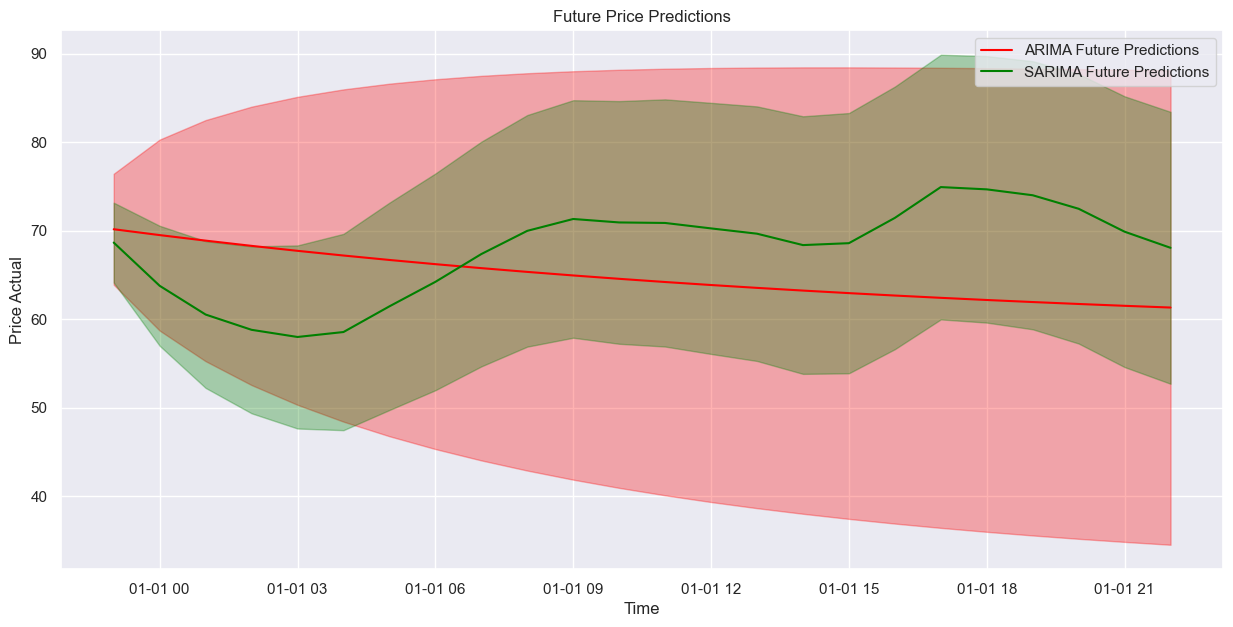

In [77]:
# Plotting future predictions
plt.figure(figsize=(15, 7))

# ARIMA Predictions
plt.plot(future_arima_forecast_values.index, future_arima_forecast_values, label='ARIMA Future Predictions', color='red')
plt.fill_between(future_arima_forecast_values.index, 
                 future_arima_conf_int.iloc[:, 0], 
                 future_arima_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)

# SARIMA Predictions
plt.plot(future_sarima_forecast_values.index, future_sarima_forecast_values, label='SARIMA Future Predictions', color='green')
plt.fill_between(future_sarima_forecast_values.index, 
                 future_sarima_conf_int.iloc[:, 0], 
                 future_sarima_conf_int.iloc[:, 1], 
                 color='green', alpha=0.3)

plt.title('Future Price Predictions')
plt.xlabel('Time')
plt.ylabel('Price Actual')
plt.legend()
plt.show()


# Other Models:
- Random Forest
- Lightgbm
- XGBoost

## Random Forest

In [78]:
#remove price day ahead column

df_time = df_time.reset_index(drop=True)


In [79]:
df_time.sort_values(by='time', inplace=True)

In [80]:
# Calculate the number of data points for training (e.g., 80% of the dataset)
split_index = int(len(df_time) * 0.8)

# Split the dataset into training and testing sets based on the calculated index
train = df_time.iloc[:split_index]
test = df_time.iloc[split_index:]

# Exclude 'time' column from features, and keep all others except the target variable 'price actual'
X_train = train.drop(['price actual', 'time'], axis=1)
y_train = train['price actual']

X_test = test.drop(['price actual', 'time'], axis=1)
y_test = test['price actual']



In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_rf = rf_model.predict(X_test)





In [82]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)  # Calculate RMSE
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest Model - MSE: {mse_rf}, RMSE: {rmse_rf}, R²: {r2_rf}, MAE: {mae_rf}")

Random Forest Model - MSE: 4.691472851212164, RMSE: 2.165980805827273, R²: 0.9646949982896356, MAE: 1.5769876784694454


c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


For the Random Forest model, the following metrics were computed to evaluate its performance:

1. MSE (Mean Squared Error): The average of the squared differences between the predicted and actual values is 4.69.
2. RMSE (Root Mean Squared Error): The square root of the MSE is 2.17, indicating the average deviation of predicted values from actual values.
3. R-squared (R²): The coefficient of determination is 0.96, suggesting that the model explains approximately 96.47% of the variability in the data, indicating a high level of fit.
4. MAE (Mean Absolute Error): The average absolute difference between the predicted and actual values is 1.58, providing a measure of the model's prediction accuracy.

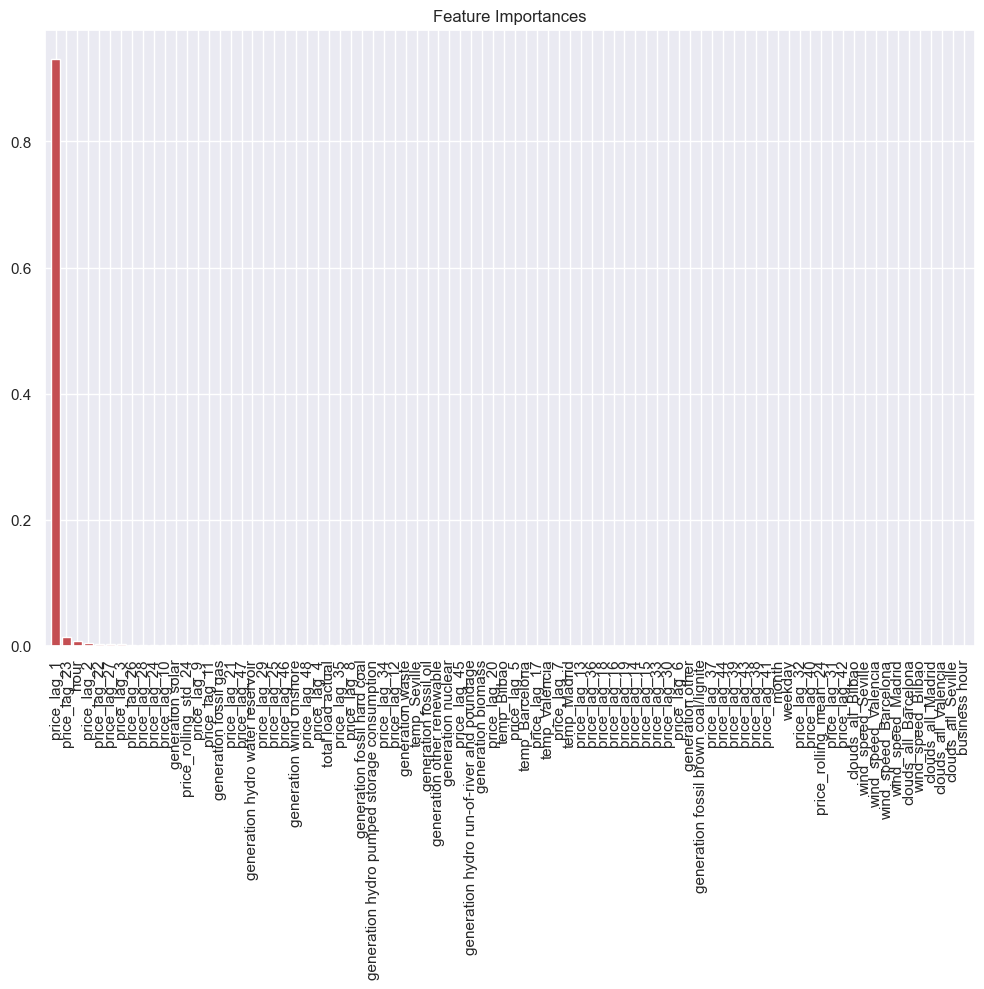

In [101]:
# Retrieve feature importances from the model
importances = rf_model.feature_importances_

# Create indices to sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))  # Adjust the size of the plot here as needed
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")

# Align feature names with their importance bars
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])

plt.show()

lightgbm

In [83]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the LightGBM model
lgbm_model = LGBMRegressor(
    n_estimators=1000,  # Number of boosted trees to fit
    learning_rate=0.01,  # Speed of learning
    num_leaves=31,  # Maximum tree leaves for base learners
    random_state=42,  # Seed for reproducibility
    early_stopping_rounds=100,
    verbose=50,
)

# Train the model
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae')

# Make predictions
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.701449
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.057065
[LightGBM] [Debug] init for col-wise cost 0.001001 seconds, init for row-wise cost 0.003507 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17975
[LightGBM] [Info] Number of data points in the train set: 28012, number of used features: 84
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] S

c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R²: {r2_train}")

print("\nTesting Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R²: {r2_test}")

Training Metrics:
MAE: 1.420514205415541
RMSE: 1.9685827245637766
R²: 0.9809027484866724

Testing Metrics:
MAE: 1.5003841048703133
RMSE: 2.0556185307441295
R²: 0.9682011014243705


### Training Metrics:
- **Mean Absolute Error (MAE):** 1.42
  - Indicates the average magnitude of the errors in a set of predictions, without considering their direction.
- **Root Mean Square Error (RMSE):** 1.97
  - Measures the average magnitude of the error, giving more weight to large errors.
- **R² (R-squared):** 0.981
  - Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A very high level of predictability.

### Testing Metrics:
- **Mean Absolute Error (MAE):** 1.50
  - Similar to the training MAE, it shows the average error magnitude in predictions on unseen data.
- **Root Mean Square Error (RMSE):** 2.06
  - Indicates the presence of larger errors in the model's predictions on the testing set compared to the training set.
- **R² (R-squared):** 0.968
  - Although slightly lower than the training R², it still signifies a very high level of predictability on the testing set.

### Overall:
The model demonstrates high accuracy and predictability, with both training and testing R² values being close to 1. The MAE and RMSE values indicate that the model's predictions are generally close to the actual values. There is a slight increase in error metrics from training to testing, which is typical as models may not perform as well on unseen data.


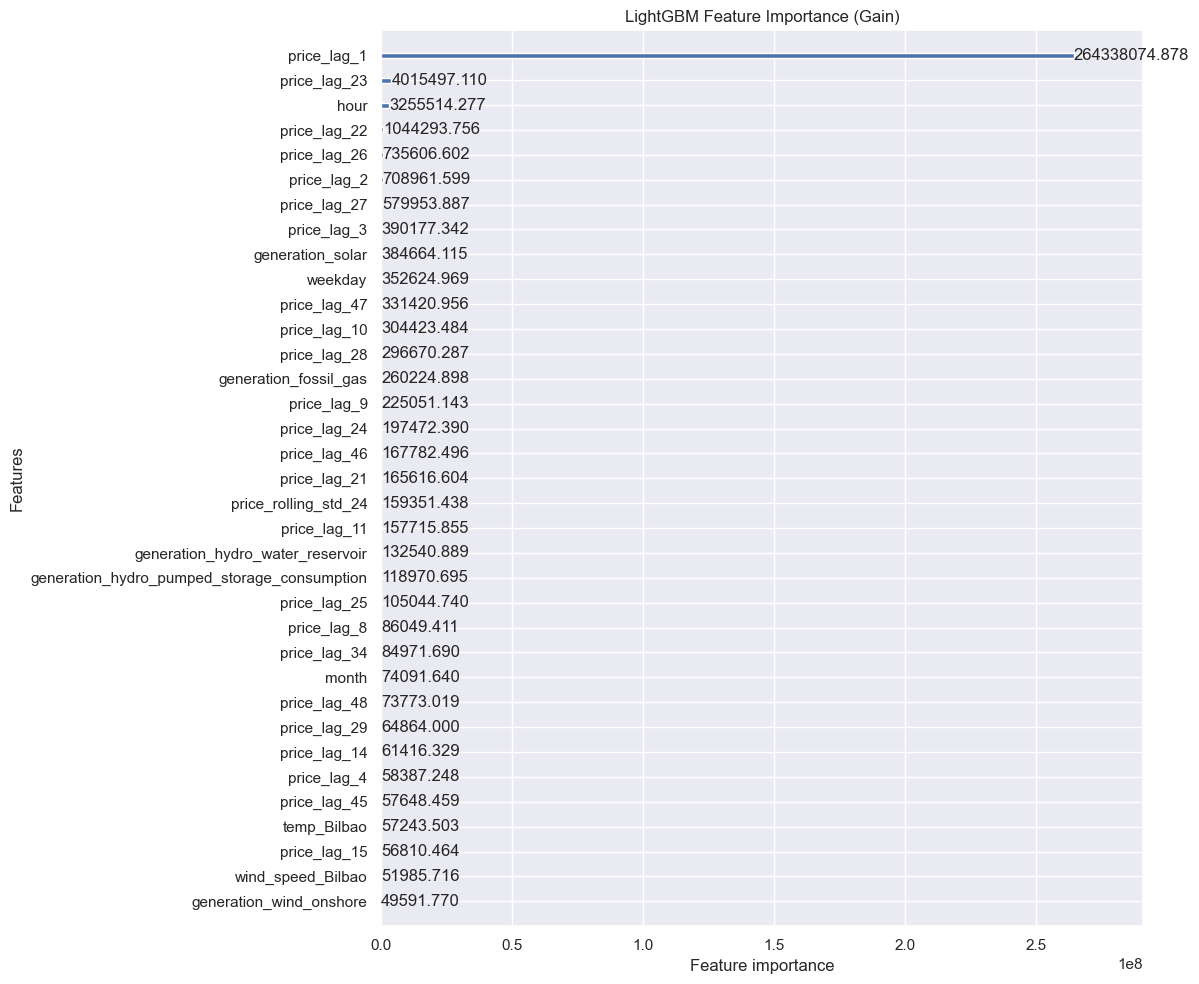

In [85]:
lgb.plot_importance(lgbm_model, importance_type="gain", figsize=(12, 10), max_num_features=35, title="LightGBM Feature Importance (Gain)")
plt.tight_layout()  # Adjust the layout
plt.show()

xgboost

In [86]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [87]:
params = {
    'max_depth': 6,  # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
    'eta': 0.3,  # The learning rate. Prevents overfitting.
    'objective': 'reg:squarederror',  # Loss function for regression tasks
    'eval_metric': 'rmse',  # Evaluation metric for the model performance
}
num_rounds = 100  # Number of training rounds


In [88]:
bst = xgb.train(params, dtrain, num_rounds)
y_pred = bst.predict(dtest)

In [89]:
# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")



Root Mean Squared Error: 2.252631592078415
Mean Squared Error: 5.0743490896297345
R² Score: 0.9618137184270232
Mean Absolute Error: 1.6695646986588282


c:\Users\Admin\Desktop\Capsotne_fin\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Figure size 2600x1800 with 0 Axes>

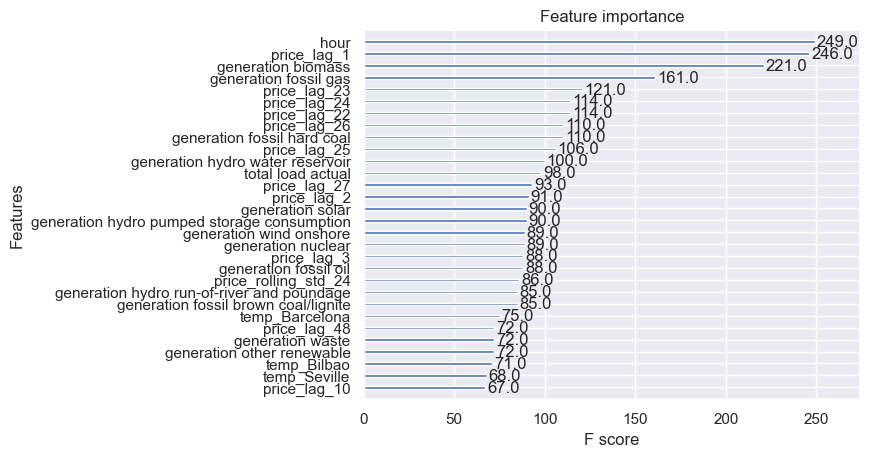

In [100]:
# Set the figure size
plt.figure(figsize=(26, 18))  # You might adjust this if it's still not enough

# Plotting the feature importance
ax = plot_importance(bst, max_num_features=30)  # Shows only top 10 features. Adjust the number as needed.
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Rotate feature names
plt.show()

## XGBoost Model Performance Metrics Summary

- **Root Mean Squared Error (RMSE):** 2.25
  - Reflects the average distance between the predicted values and the actual values. Indicates an average error of about 2.25 units.

- **Mean Squared Error (MSE):** 5.07
  - Represents the average of the squares of the errors. The value is relatively low, suggesting a generally good performance by the model.

- **R² Score:** 0.962
  - Measures the proportion of variance in the dependent variable that is predictable from the independent variables. A score close to 1 indicates a strong model fit to the data.

- **Mean Absolute Error (MAE):** 1.67
  - The average absolute difference between predicted and actual values, suggesting a decent level of precision in the predictions.

Overall, the metrics indicate that the XGBoost model has a strong predictive ability, with a high R² Score signifying that most of the variability is captured by the model. However, the RMSE value points to the presence of some larger errors in the predictions.




# Model Metrics Comparision:


| Model          | Metric          | Value     |
|----------------|-----------------|-----------|
| **ARIMA**      | MAE             | 8.8412    |
|                | RMSE            | 9.6174    |
|                | MAPE            | 12.8147%  |
|                | R² Score        | -1.1222   |
| **SARIMA**     | MAE             | 1.9211    |
|                | RMSE            | 2.2754    |
|                | MAPE            | 2.7590%   |
|                | R² Score        | 0.8812    |
| **Random Forest** | MSE          | 4.6915    |
|                | RMSE            | 2.1660    |
|                | R² Score        | 0.9647    |
|                | MAE             | 1.5770    |
| **LightGBM (Train)** | MAE       | 1.4205    |
|                | RMSE            | 1.9686    |
|                | R² Score        | 0.9809    |
| **LightGBM (Test)**  | MAE       | 1.5004    |
|                | RMSE            | 2.0556    |
|                | R² Score        | 0.9682    |
| **XGBoost**    | MAE             | 1.6696    |
|                | RMSE            | 2.2526    |
|                | MSE             | 5.0743    |
|                | R² Score        | 0.9618    |


### Conclusion: Preference for SARIMA Model

After evaluating various models, including LightGBM, Random Forest, and XGBoost, against our need to capture the temporal dynamics of our dataset, **SARIMA** emerges as our model of choice. Despite the strong predictive capabilities of machine learning models, SARIMA's specialized handling of seasonal patterns and trends makes it uniquely suited for time series forecasting.

SARIMA's performance metrics reveal its competence in modeling time-dependent data, with significant improvements over ARIMA and a competitive R² Score. Its ability to directly incorporate temporal structure—without extensive feature engineering—aligns perfectly with our analytical objectives, making it the most appropriate choice for leveraging the temporal nature of our data.

In conclusion, SARIMA's tailored approach to time series forecasting and its effective use of our dataset's temporal characteristics firmly establish it as our preferred model.

